In [1]:
import numpy as np
import pandas as pd
import glob
import os
from omegaconf import OmegaConf
import skimage
from tqdm.notebook import tqdm, trange

In [2]:
# Define parameters here
start_date = "2024-02-19"
max_images = 424242
output_path = "../outputs"
target_path = "../data/raw/train_kelp/"

In [3]:
# Search for suitable output folders
folders = []
confs = dict()
for day_folder in glob.glob(os.path.join(output_path, "*/")):
    if day_folder.split(os.sep)[-2] < start_date:
        continue       
    for timestamp_folder in glob.glob(os.path.join(day_folder, "*/")):
        if not os.path.exists(os.path.join(timestamp_folder, "preds")):
            continue
        
        # read the .hydra/config.yaml file with omegaconf into a dictionary
        with open(os.path.join(timestamp_folder, ".hydra", "config.yaml"), "r") as f:
            cfg = OmegaConf.load(f)
            
        if "test_size" not in cfg or cfg.test_size != 0.2:
            continue
        
        confs[timestamp_folder] = cfg            
        print(timestamp_folder)
        folders.append(timestamp_folder)
print(f"Found {len(folders)} suitable folders")

../outputs\2024-02-19\14-58-07\
../outputs\2024-02-19\15-16-43\
../outputs\2024-02-19\15-55-52\
../outputs\2024-02-19\16-01-33\
../outputs\2024-02-19\16-24-33\
../outputs\2024-02-19\16-37-53\
../outputs\2024-02-19\16-49-42\
../outputs\2024-02-19\17-22-32\
../outputs\2024-02-19\17-38-08\
../outputs\2024-02-19\17-50-54\
../outputs\2024-02-19\17-55-40\
../outputs\2024-02-19\18-13-00\
../outputs\2024-02-19\18-40-20\
../outputs\2024-02-19\23-38-11\
../outputs\2024-02-19\23-51-19\
../outputs\2024-02-19\23-52-02\
../outputs\2024-02-19\23-53-38\
../outputs\2024-02-20\01-16-30\
../outputs\2024-02-20\09-57-58\
../outputs\2024-02-20\09-58-57\
../outputs\2024-02-20\10-01-40\
../outputs\2024-02-20\10-09-29\
../outputs\2024-02-20\14-42-33\
../outputs\2024-02-20\15-25-02\
../outputs\2024-02-20\23-52-02\
../outputs\2024-02-21\00-13-01\
Found 26 suitable folders


In [4]:
# Filter out folders with identical configurations
unique_confs = dict()
for folder, conf in confs.items():
    if conf not in unique_confs.values():
        unique_confs[folder] = conf
folders = list(unique_confs.keys())
print(f"Remaining folders: {len(folders)}")

Remaining folders: 23


In [5]:
# Read the filenames inside the first folder
filenames = glob.glob(os.path.join(folders[0], "preds", "*.tif"))
image_names = [os.path.basename(f)[:-9] for f in filenames]

In [6]:
# have a dictionary of the feature combinations:
feature_combinations = {
    "f13": [0,1,2,3,4,7,8,9,10,11,12,13,14],
    "f18": [0,1,2,3,4,7,8,9,10,11,12,13,14,15,16,17,18,19],
    "fm1": [0,1,2,7,13,14,18,19],
    "fm2": [0,1,2,3,4,12,19],
    "fm3": [7,8,9,10,11,12,13,14,15,16,17,18,19],
    "fm4": [0,1,2,3,4,19], 
}

In [7]:
# Create a name based on the config
names = dict()
for folder in folders:
    conf = confs[folder]
    name = conf.model.model_loop_pipeline.model_blocks_pipeline.model_blocks[0].model.model._target_.split(".")[-1]
    if name == "Unet":
        name = f"{conf.model.model_loop_pipeline.model_blocks_pipeline.model_blocks[0].model.model.encoder_name}-{name}"
        
    # find the feature name based on the column selection
    for feature_name, feature_columns in feature_combinations.items():
        if feature_columns == conf.model.model_loop_pipeline.pretrain_pipeline.pretrain_steps[1].columns:
            name += f"-{feature_name}"
            break

    name += f"-bs{conf.model.model_loop_pipeline.model_blocks_pipeline.model_blocks[0].batch_size}"
    name += f"-e{conf.model.model_loop_pipeline.model_blocks_pipeline.model_blocks[0].epochs}"
    name += f"-{conf.model.model_loop_pipeline.model_blocks_pipeline.model_blocks[0].criterion._target_.split('.')[-1]}"
    names[folder] = name
for folder, name in names.items():
    print(folder, name)

../outputs\2024-02-19\14-58-07\ vgg13-Unet-f18-bs16-e75-FocalDiceBoundaryLoss
../outputs\2024-02-19\15-16-43\ vgg13-Unet-f13-bs16-e75-DiceLoss
../outputs\2024-02-19\15-55-52\ vgg13-Unet-f18-bs16-e75-DiceLoss
../outputs\2024-02-19\16-01-33\ SwinUNETR-f13-bs16-e75-DiceLoss
../outputs\2024-02-19\16-24-33\ vgg13-Unet-f18-bs16-e75-DiceLoss
../outputs\2024-02-19\16-37-53\ vgg13-Unet-fm4-bs16-e75-DiceLoss
../outputs\2024-02-19\16-49-42\ vgg13-Unet-fm2-bs16-e75-DiceLoss
../outputs\2024-02-19\17-22-32\ vgg13-Unet-f18-bs16-e75-FocalDice2BoundaryLoss
../outputs\2024-02-19\17-38-08\ SwinUNETR-f18-bs16-e75-FocalDiceBoundaryLoss
../outputs\2024-02-19\17-50-54\ vgg13-Unet-f13-bs16-e75-FocalDiceBoundaryLoss
../outputs\2024-02-19\17-55-40\ SwinUNETR-f13-bs16-e75-FocalDiceBoundaryLoss
../outputs\2024-02-19\18-13-00\ timm-resnest14d-Unet-f13-bs16-e75-DiceLoss
../outputs\2024-02-19\18-40-20\ timm-res2net50_26w_4s-Unet-f13-bs16-e75-DiceLoss
../outputs\2024-02-19\23-38-11\ timm-res2net50_26w_4s-Unet-f18-bs1

In [8]:
# Take the first max_images images
image_selection = image_names[:min(max_images, len(image_names))]

In [9]:
# Load the target tiffs into an array
targets = []
for image_name in tqdm(image_selection):
    target = skimage.io.imread(os.path.join(target_path, f"{image_name}_kelp.tif"))
    targets.append(target)
targets = np.array(targets).flatten()

  0%|          | 0/1127 [00:00<?, ?it/s]

In [10]:
# Load the predictions into an array
predictions = dict()
for folder in tqdm(folders):
    preds = []
    for image_name in image_selection:
        pred = skimage.io.imread(os.path.join(folder, "preds", f"{image_name}_pred.tif"))
        preds.append(pred)
    predictions[folder] = np.array(preds).flatten()

  0%|          | 0/23 [00:00<?, ?it/s]

In [11]:
# Calculate the dice scores and square error
dice_scores = dict()
square_errors = dict()
for folder, preds in tqdm(predictions.items()):
    preds = preds > 0.5
    dice_scores[folder] = 2 * np.sum(targets * preds) / (np.sum(targets) + np.sum(preds))   
    square_errors[folder] = np.mean((targets - preds) ** 2)

  0%|          | 0/23 [00:00<?, ?it/s]

In [12]:
# Remove all models with dice score below 0.6
folders = [folder for folder in folders if dice_scores[folder] > 0.6]
print(f"Remaining models: {len(folders)}")

Remaining models: 23


In [13]:
# Sort the folders by dice score
folders = sorted(folders, key=lambda folder: dice_scores[folder], reverse=True)

In [14]:
# Create a dataframe with the results
df = pd.DataFrame({
    "name": [names[folder] for folder in folders],
    "dice_score": [dice_scores[folder] for folder in folders],
    "square_error": [square_errors[folder] for folder in folders]
})

In [15]:
# Create a scatterplot with plotly express
import plotly.express as px
fig = px.scatter(df, x="dice_score", y="square_error", text="name")
fig.show()

In [15]:
for i in folders:
    print(i)

../outputs\2024-02-20\09-58-57\
../outputs\2024-02-20\14-42-33\
../outputs\2024-02-19\17-38-08\
../outputs\2024-02-21\00-13-01\
../outputs\2024-02-19\17-22-32\
../outputs\2024-02-19\17-50-54\
../outputs\2024-02-19\15-55-52\
../outputs\2024-02-20\10-09-29\
../outputs\2024-02-19\14-58-07\
../outputs\2024-02-19\23-51-19\
../outputs\2024-02-19\16-01-33\
../outputs\2024-02-20\09-57-58\
../outputs\2024-02-19\15-16-43\
../outputs\2024-02-19\18-40-20\
../outputs\2024-02-19\16-37-53\
../outputs\2024-02-19\17-55-40\
../outputs\2024-02-20\10-01-40\
../outputs\2024-02-19\16-49-42\
../outputs\2024-02-19\18-13-00\
../outputs\2024-02-19\23-53-38\
../outputs\2024-02-19\23-38-11\
../outputs\2024-02-20\15-25-02\
../outputs\2024-02-19\16-24-33\


(138057500,)
CustomTimm-f18-bs16-e75-FocalDiceBoundaryLoss
vgg13-Unet-f18-bs16-e100-FocalDiceBoundaryLoss
SwinUNETR-f18-bs16-e75-FocalDiceBoundaryLoss
vgg13-Unet-f18-bs16-e75-FocalDice2BoundaryLoss
timm-res2net50_26w_4s-Unet-f13-bs16-e100-FocalDiceBoundaryLoss
SwinUNETR-f13-bs16-e75-FocalDiceBoundaryLoss


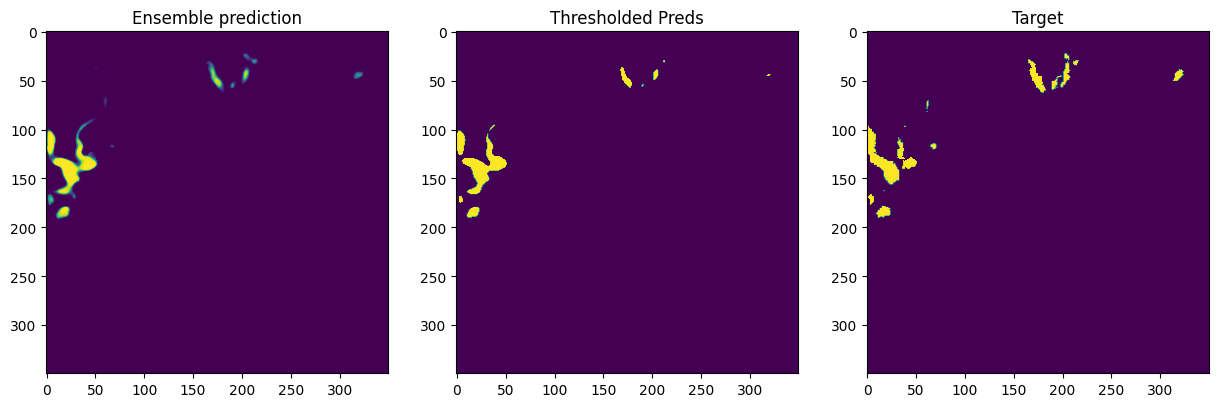

In [94]:
# Create an array of zeros that has the reshaped shape of the images
print(targets.shape)
reshaped_targets = targets.reshape(-1, 350, 350)
reshaped_predictions = dict()

best_submission_folders = ["../outputs\\2024-02-20\\15-25-02\\", "../outputs\\2024-02-20\\09-58-57\\", "../outputs\\2024-02-19\\17-38-08\\",
                           "../outputs\\2024-02-19\\17-22-32\\", "../outputs\\2024-02-20\\10-09-29\\", "../outputs\\2024-02-19\\17-55-40\\"]
for folder in best_submission_folders:
    print(names[folder])
for folder in folders:
    if folder in best_submission_folders:
        # for each folders images reshape them back to 350x350
        reshaped_predictions[folder] = predictions[folder].reshape(-1, 350, 350)
# Take the mean of all the prediction dicts per image so we end up with ensemble preds
ensemble_preds = np.mean([preds for preds in reshaped_predictions.values()], axis=0)

# Visualize the ensemble predictions
import matplotlib.pyplot as plt
n = 1


# Now plot all the 3 things plotted above in a single figure
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(ensemble_preds[n])
ax[0].set_title("Ensemble prediction")
# plot the thresholded preds
ensemble_preds = ensemble_preds > 0.5
ax[1].imshow(ensemble_preds[n])
ax[1].set_title("Thresholded Preds")
ax[2].imshow(reshaped_targets[n])
ax[2].set_title("Target")
plt.show()


In [95]:
# now compute the dice score for the ensemble preds
ensemble_dice_score = 2 * np.sum(reshaped_targets * ensemble_preds) / (np.sum(reshaped_targets) + np.sum(ensemble_preds))
print(ensemble_dice_score)

0.7168834709951278


In [96]:
# given the labels find the image that has the smallest number of zeros
min_zeros = 350*350
min_zeros_index = 0
for i in range(reshaped_targets.shape[0]):
    zeros = np.count_nonzero(reshaped_targets[i] == 0)
    if zeros < min_zeros:
        min_zeros = zeros
        min_zeros_index = i
print(min_zeros, min_zeros_index)

107120 202


In [97]:
import numpy as np
from scipy.ndimage import label
from numpy import bincount


In [98]:
def find_small_blobs(image):
    # Label the blobs
    labeled_array, num_features = label(image)

    # Fast pixel counting for each label
    # Note: We skip the first count (background) by slicing `[1:]`
    # Add a zero at the start to align label indices with counts indices
    blob_sizes = bincount(labeled_array.flat)[1:]
    blob_sizes = np.insert(blob_sizes, 0, 122500, axis=0)

    # Identify labels that meet the criteria (<= 15 pixels)
    valid_labels = np.where(blob_sizes <= 15)[0]

    # Generate the binary mask
    # Use `np.isin` for a vectorized check if each label in `labeled_array` is in `valid_labels`
    binary_mask = np.isin(labeled_array, valid_labels).astype(int)
    return binary_mask


In [99]:
blobs = np.zeros_like(ensemble_preds)
for i in range(ensemble_preds.shape[0]):
    small_blobs = find_small_blobs(ensemble_preds[i])
    blobs[i] = small_blobs


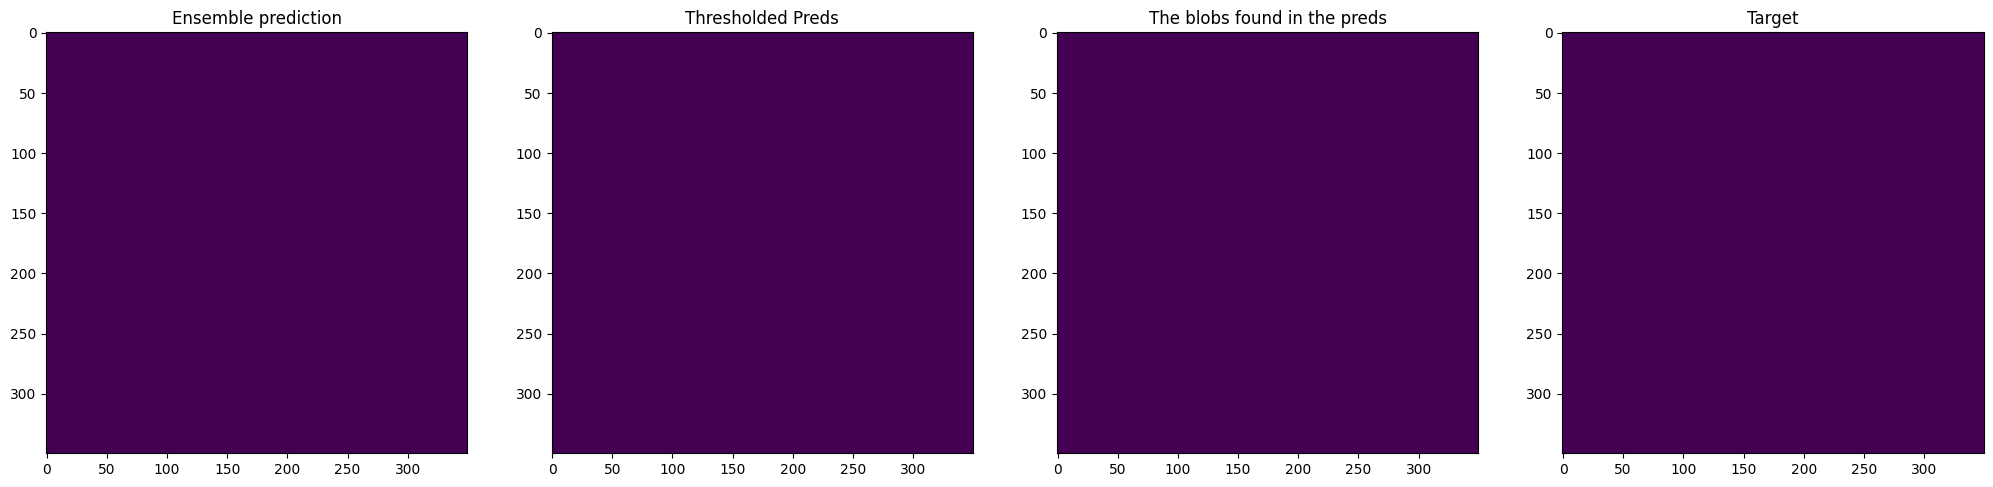

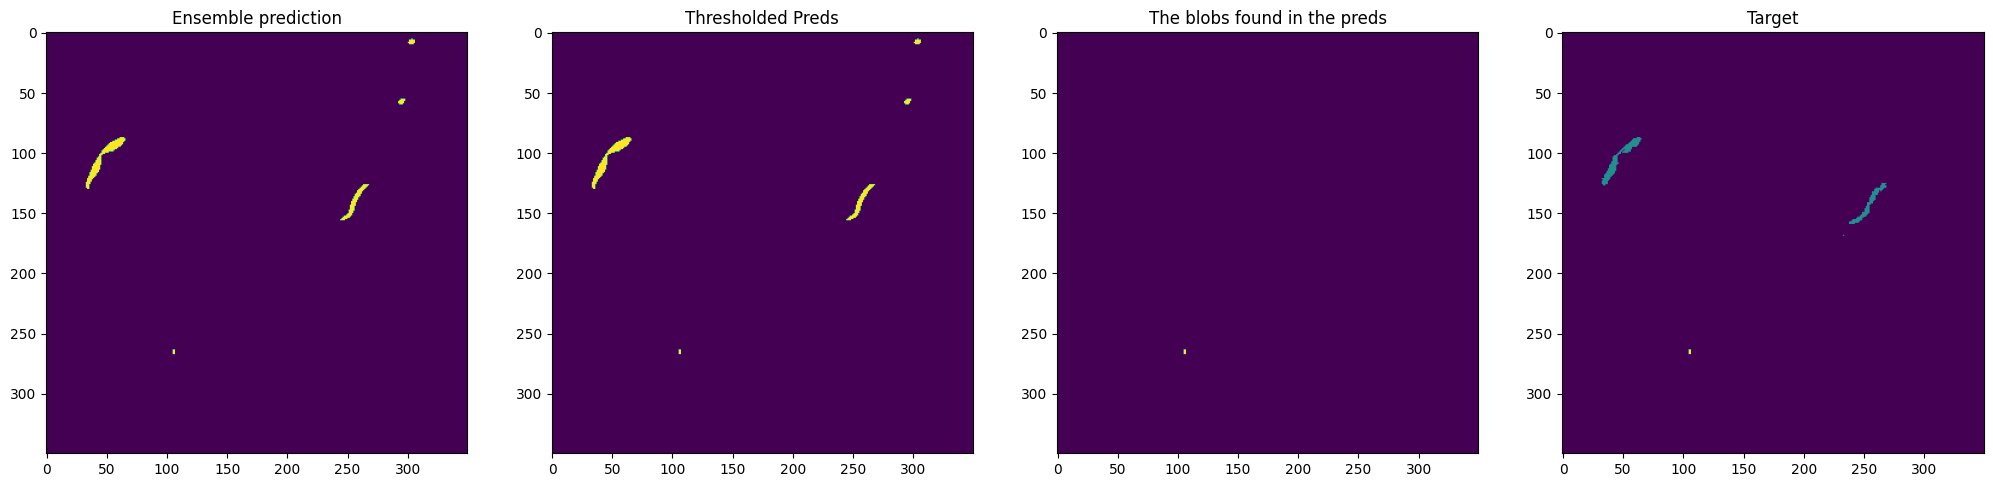

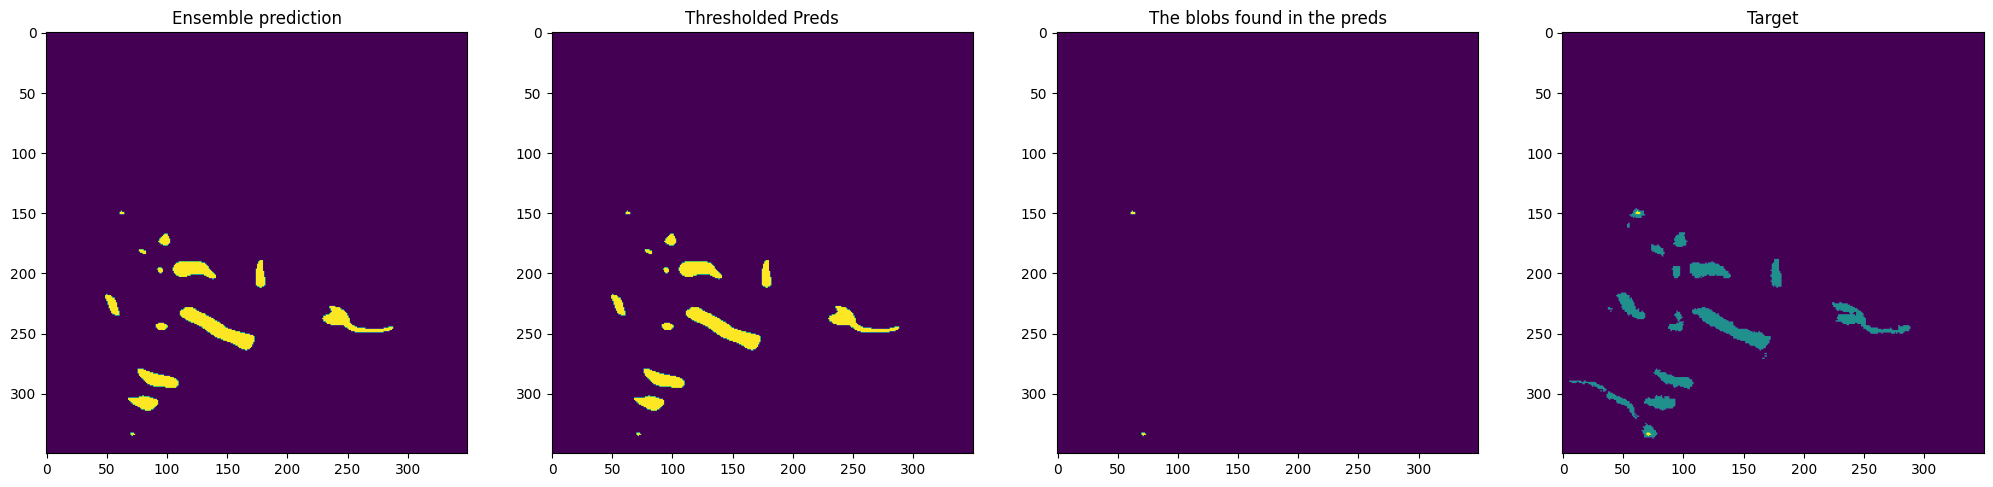

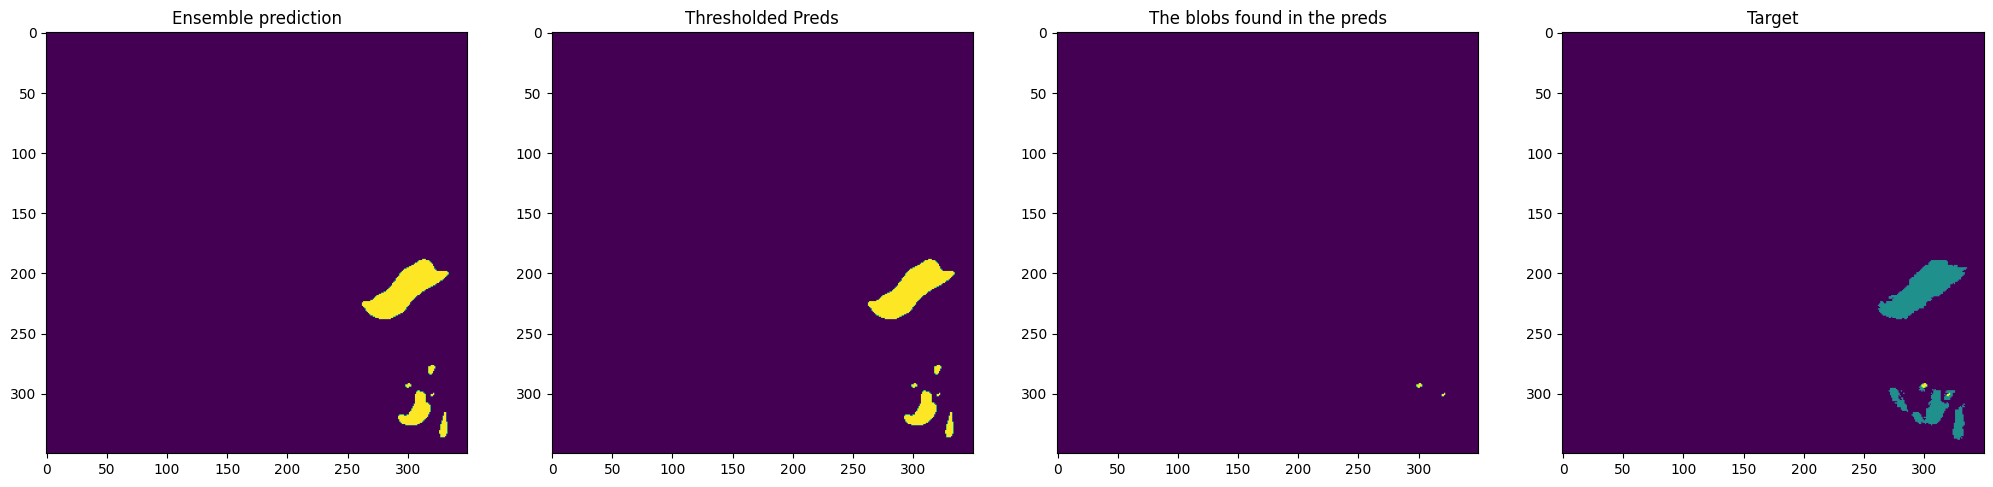

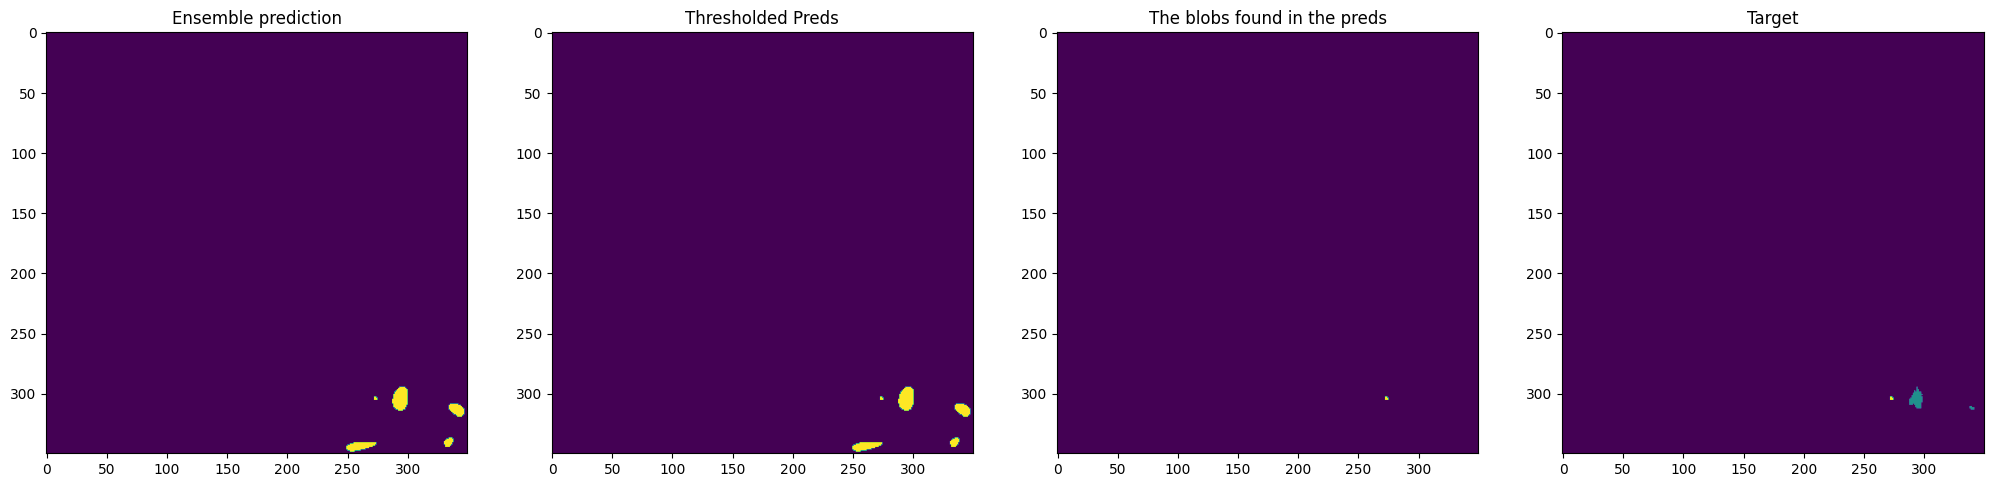

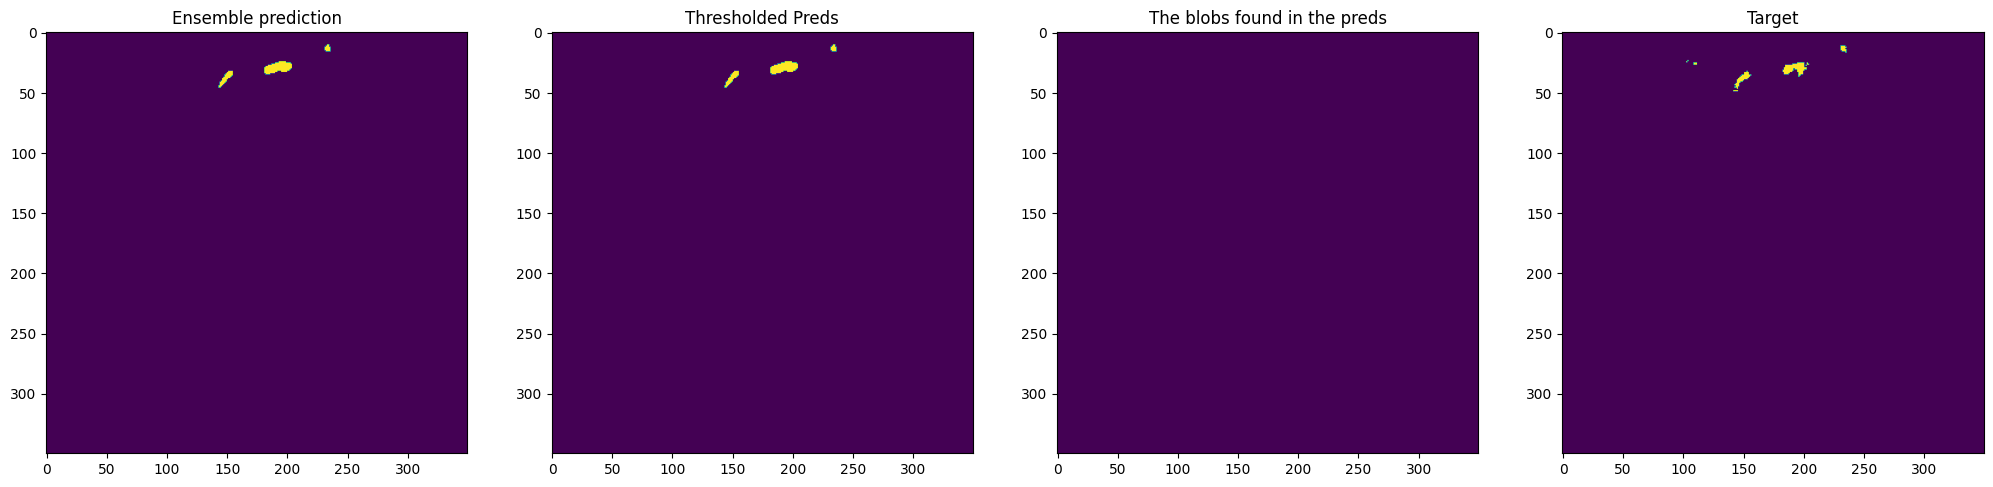

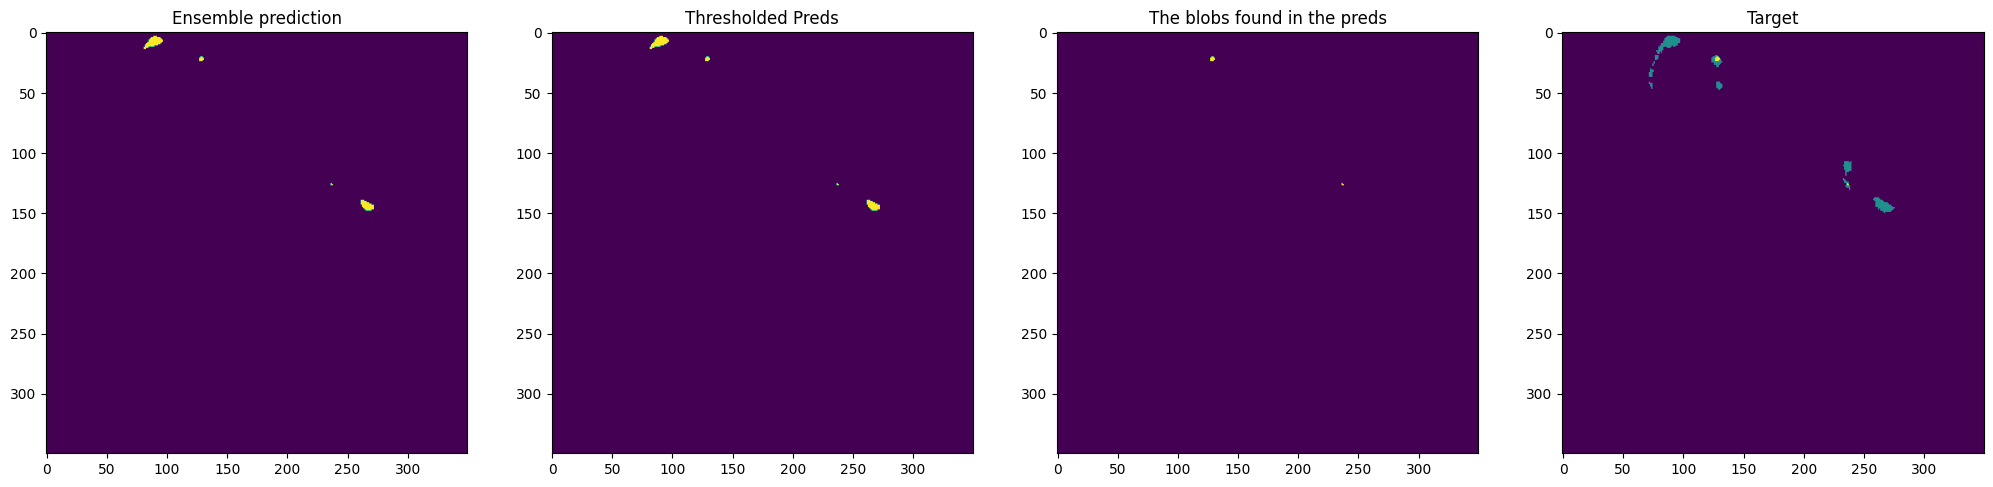

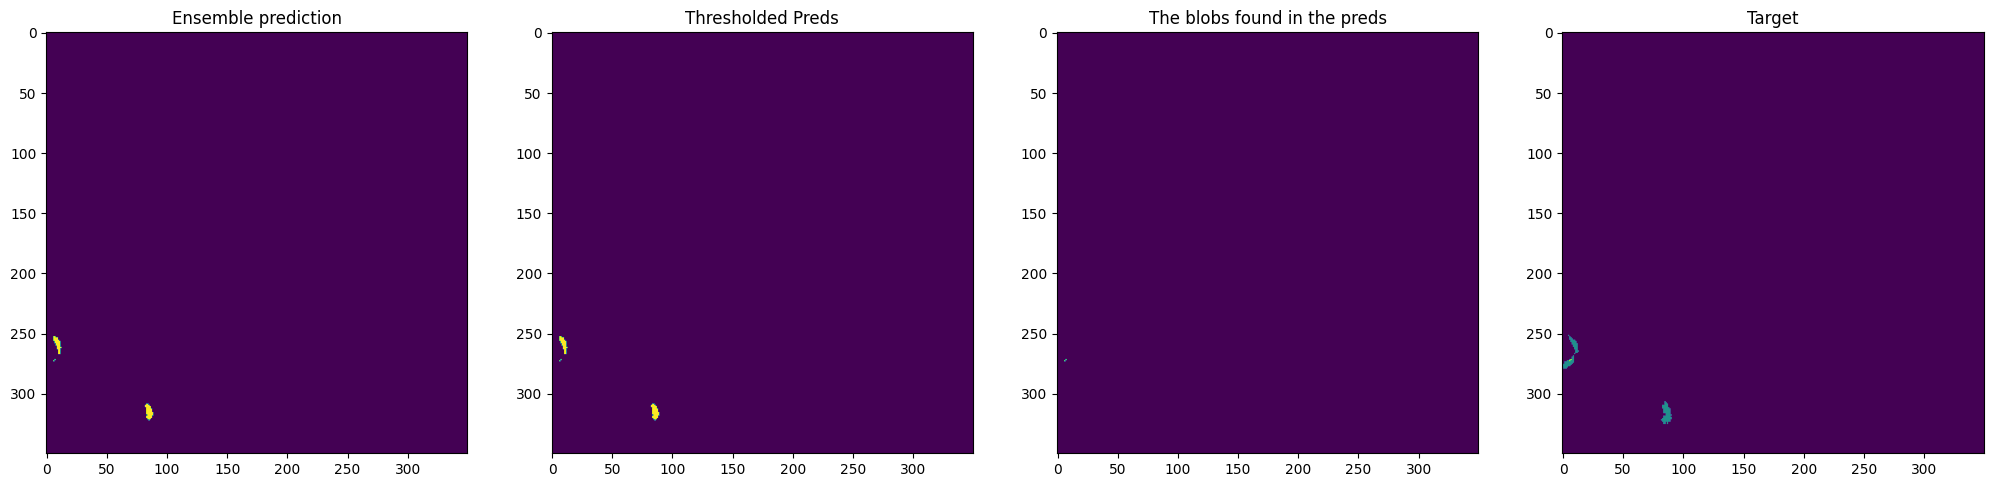

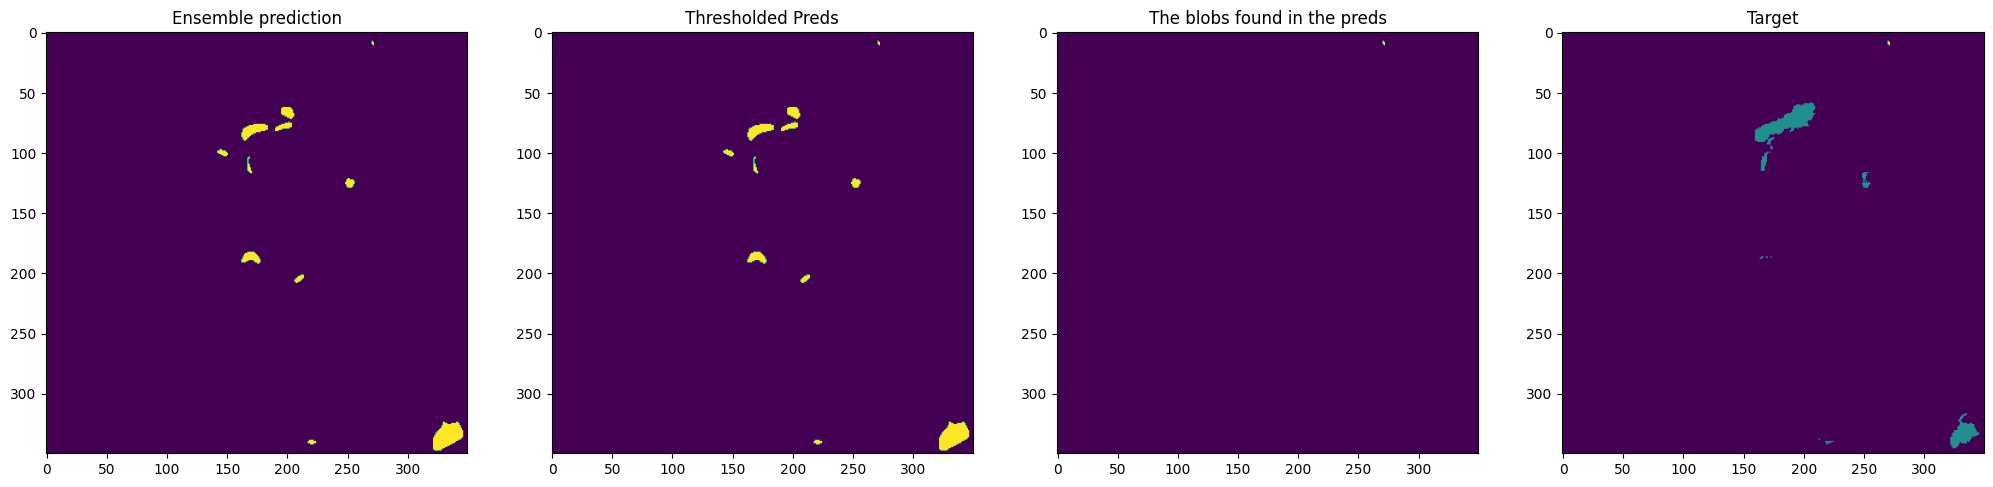

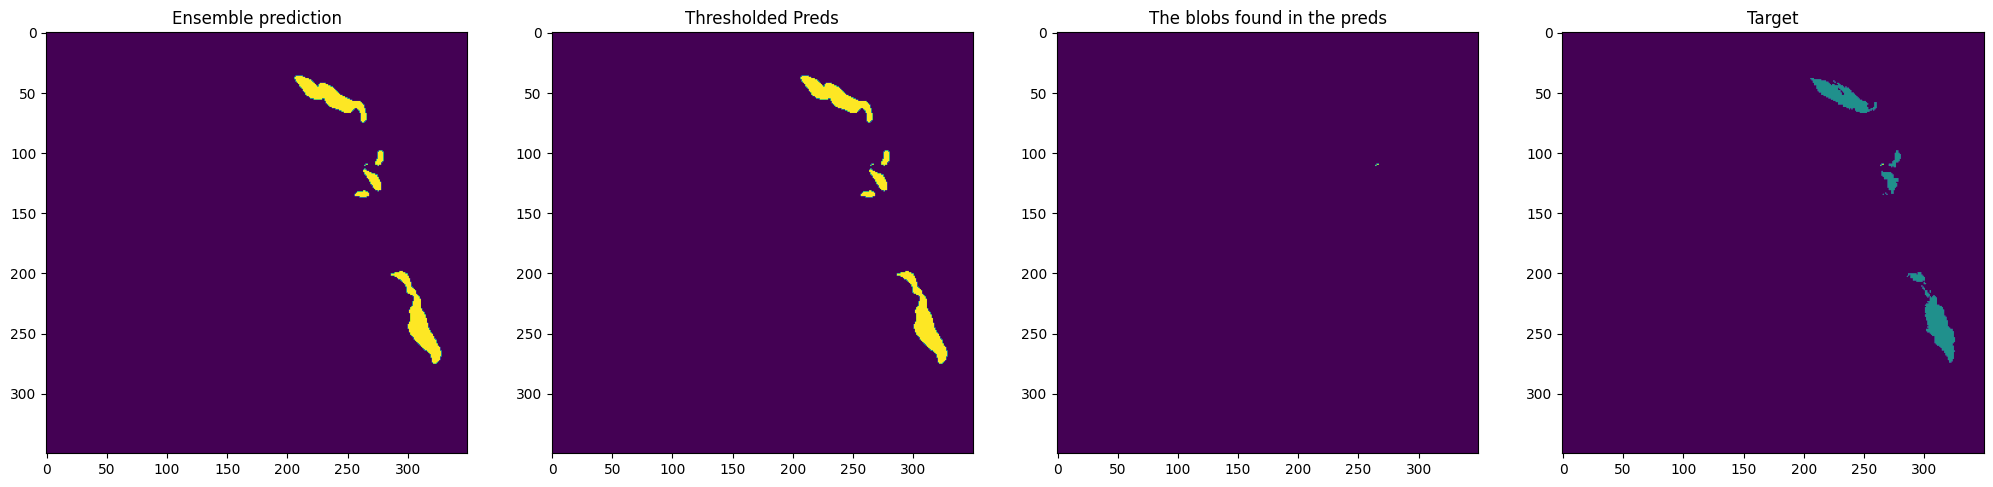

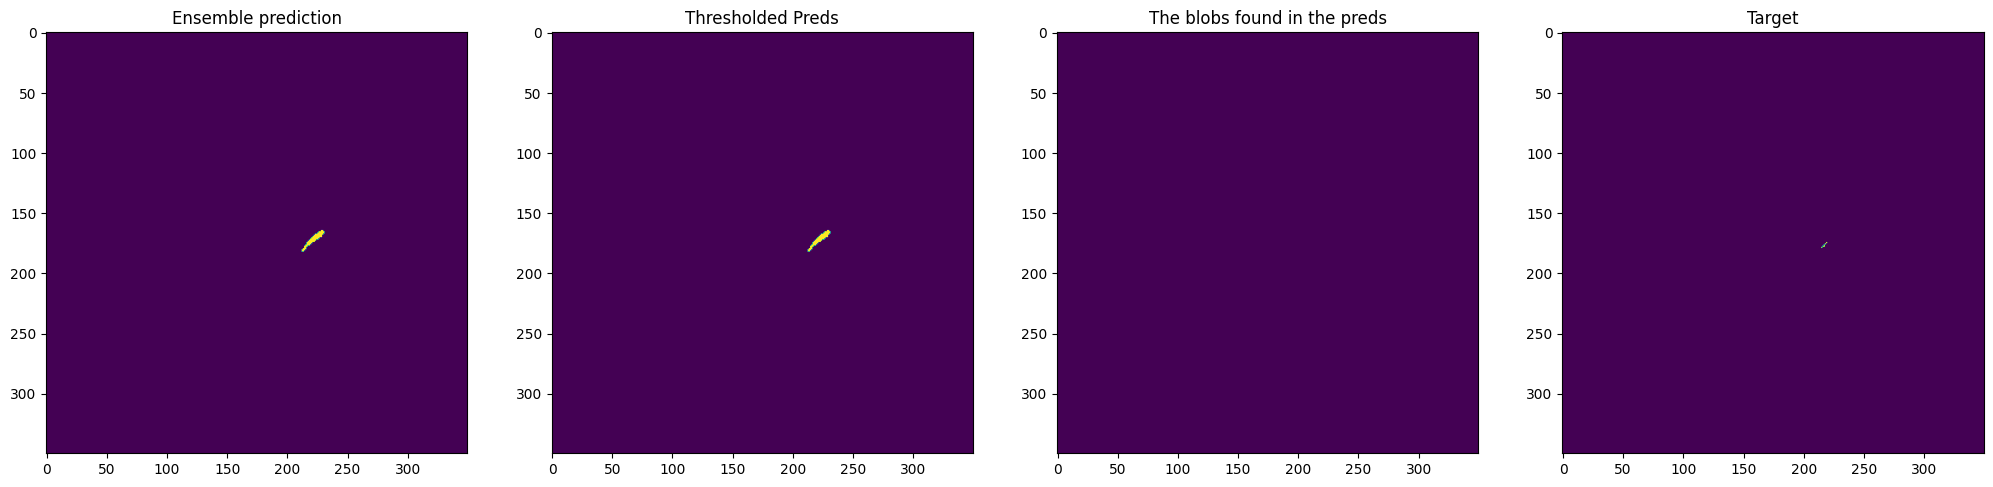

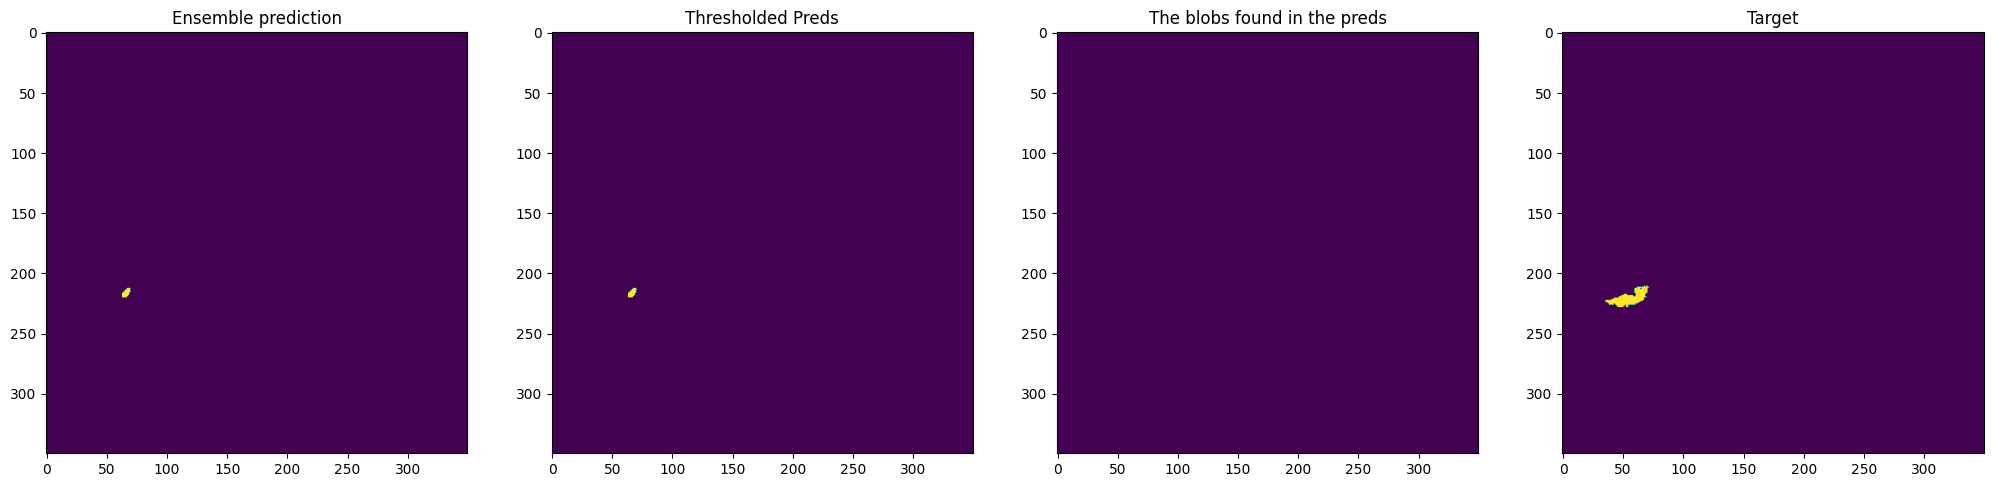

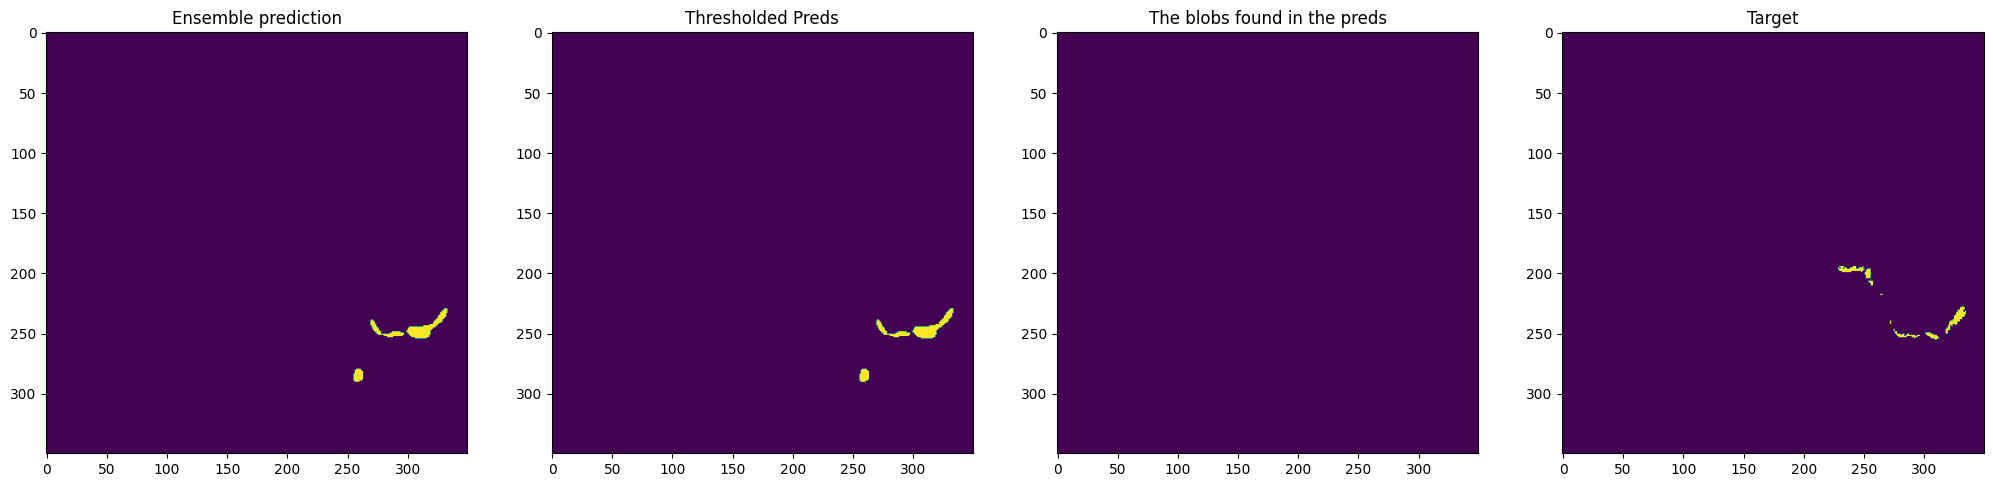

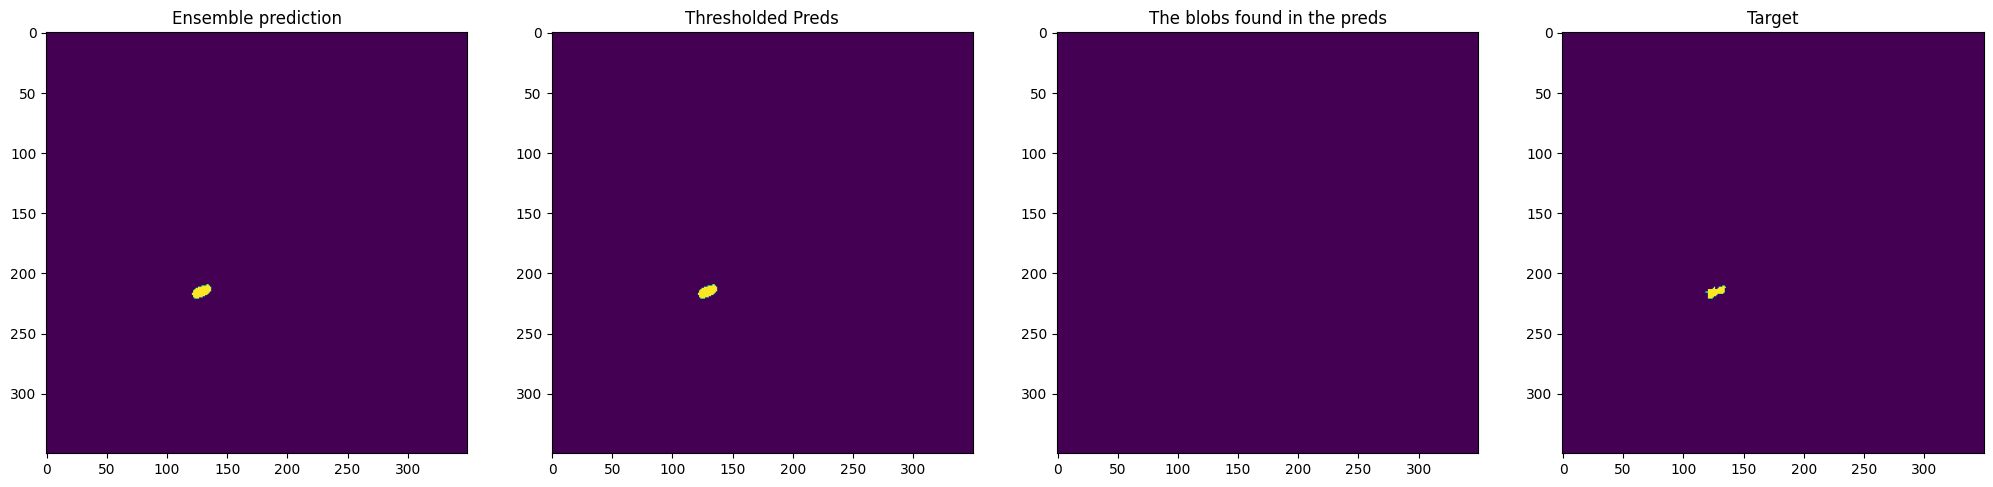

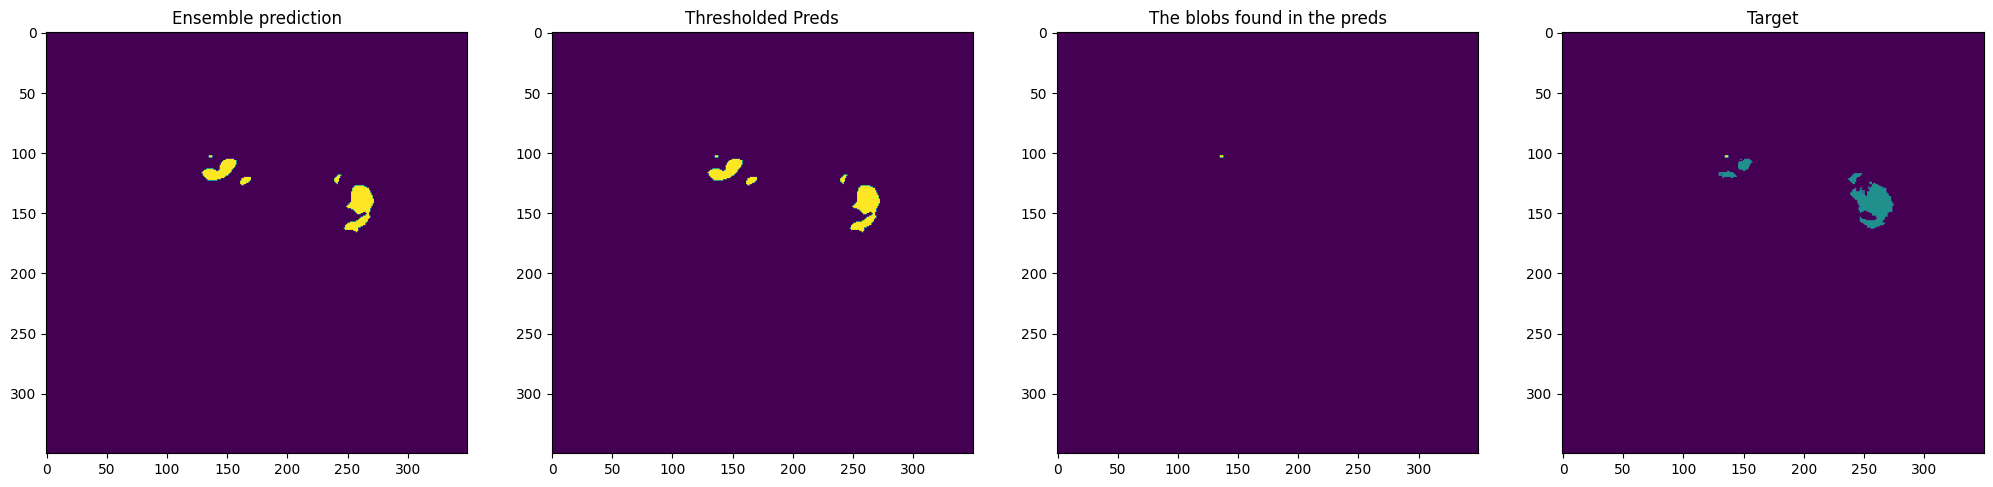

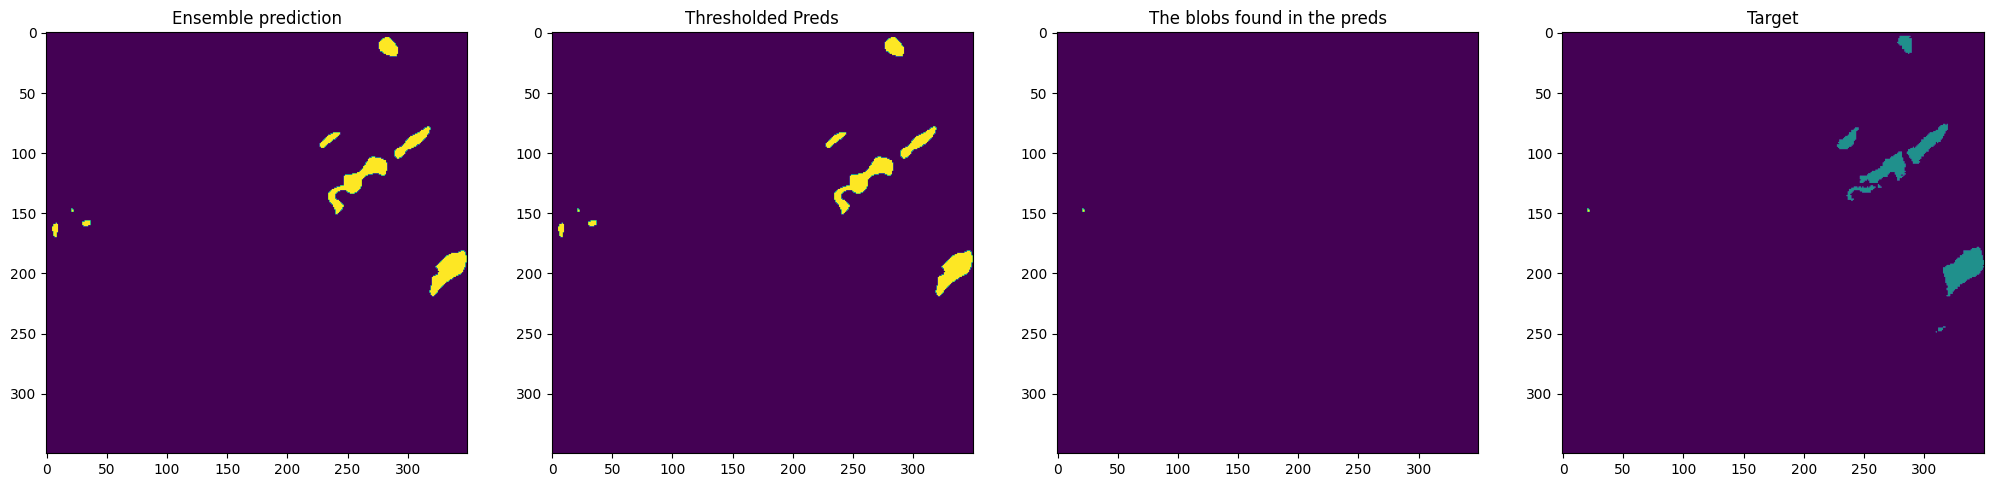

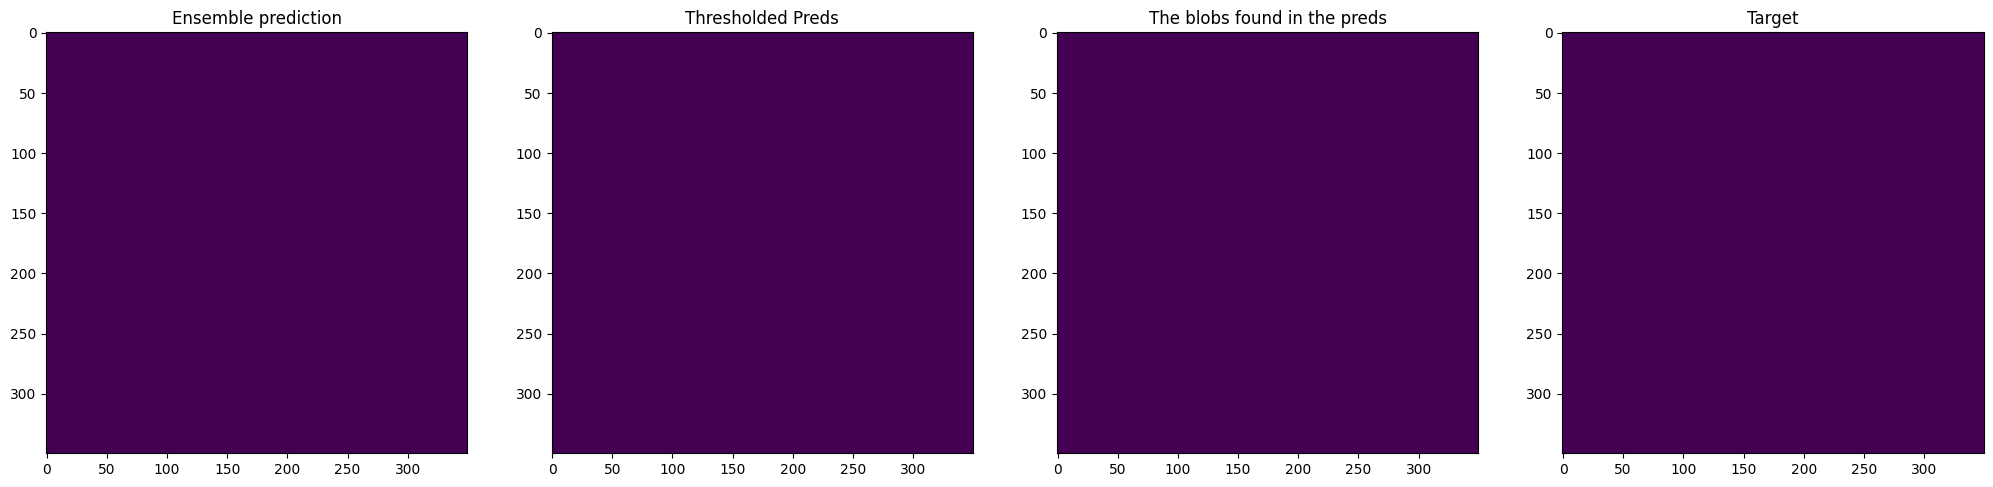

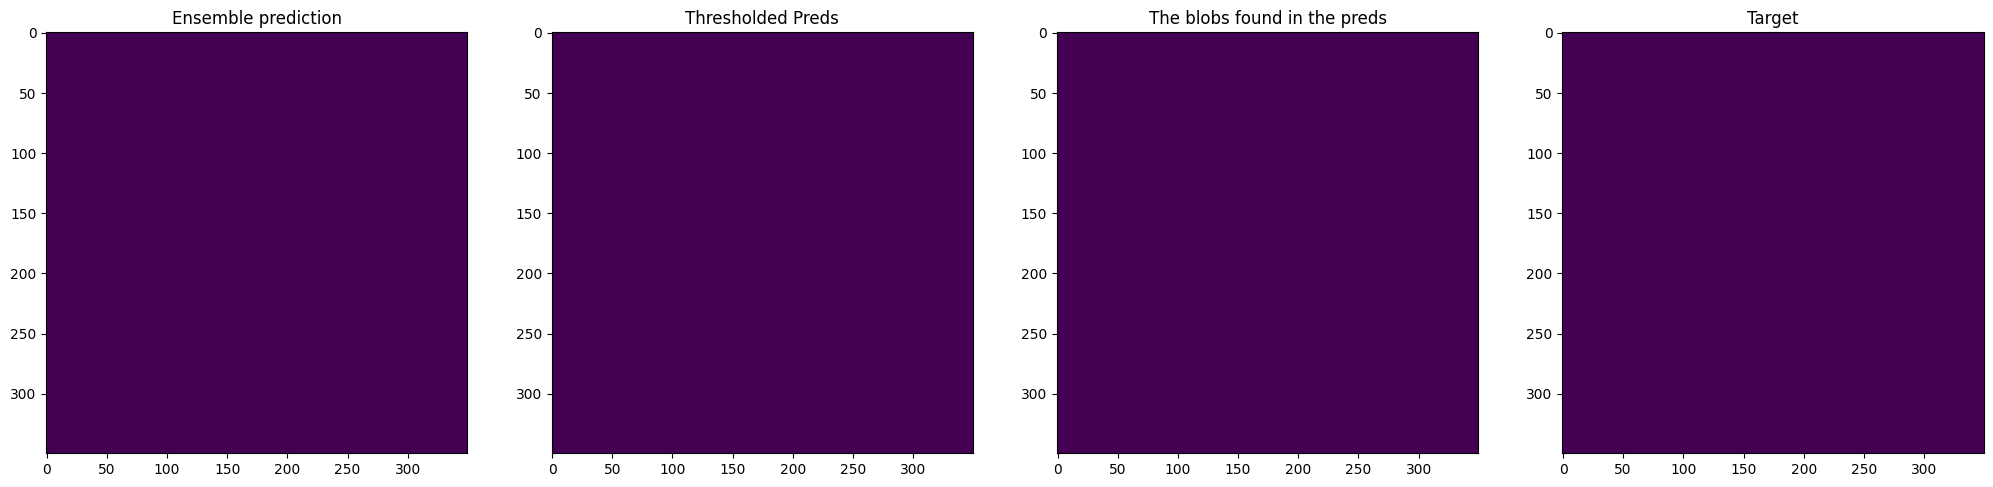

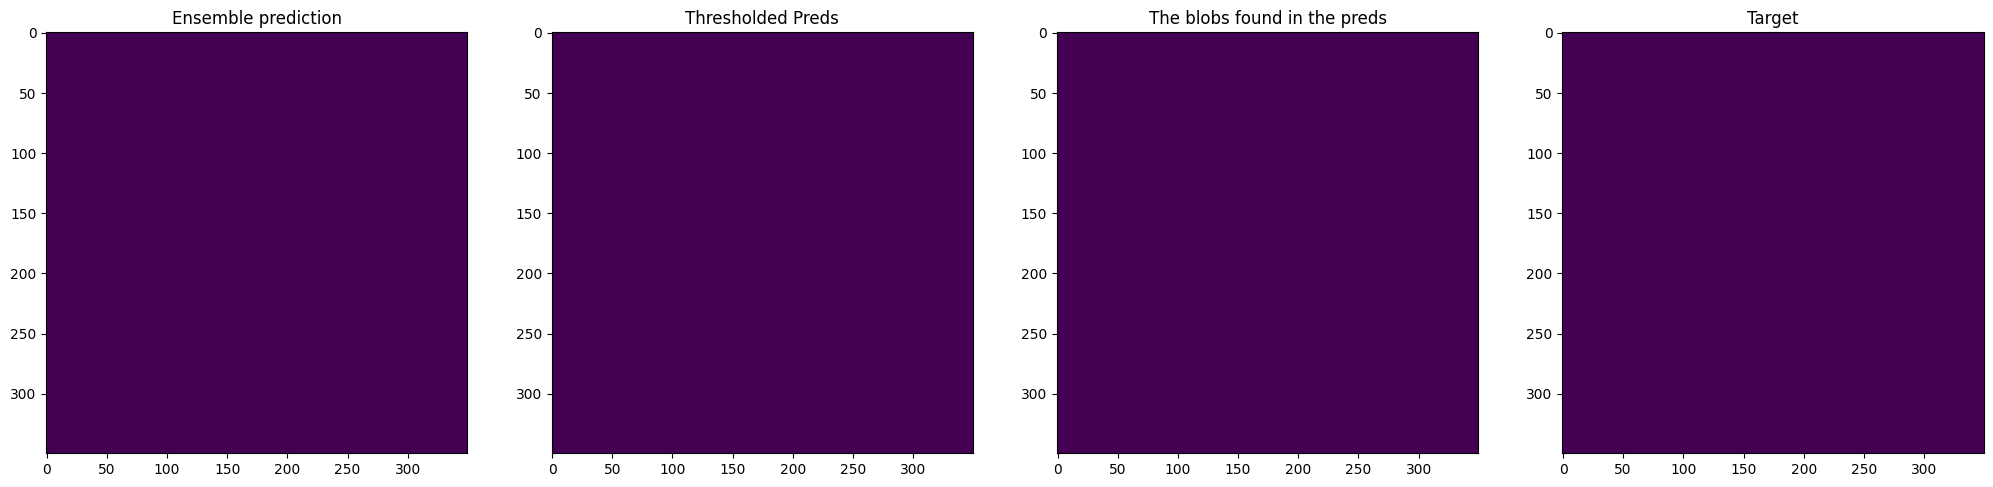

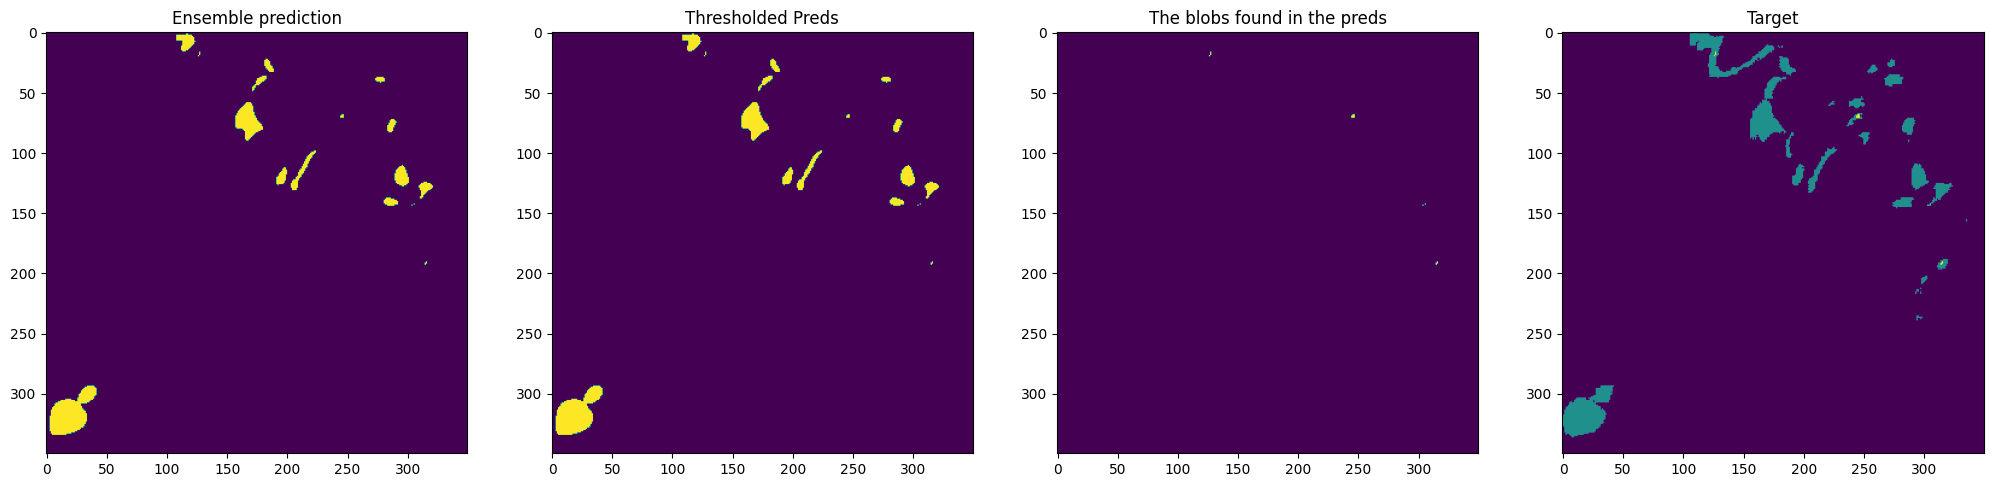

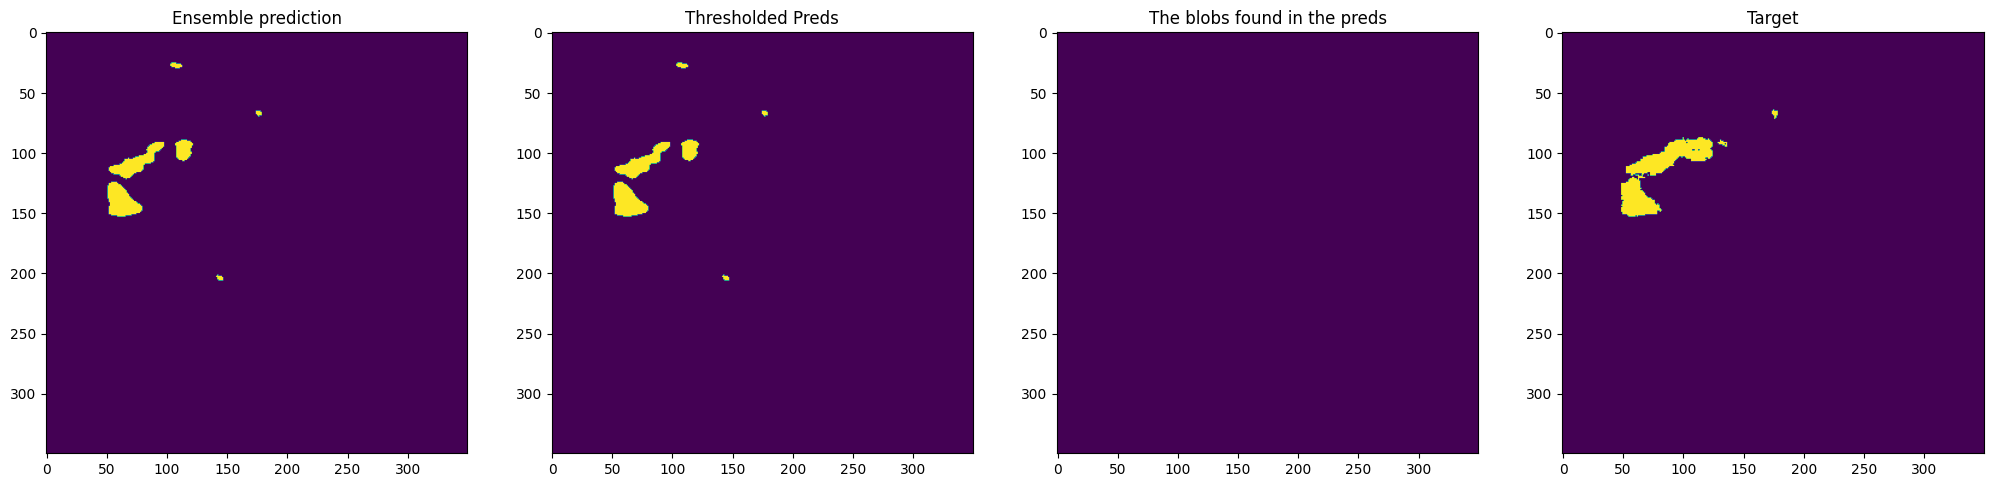

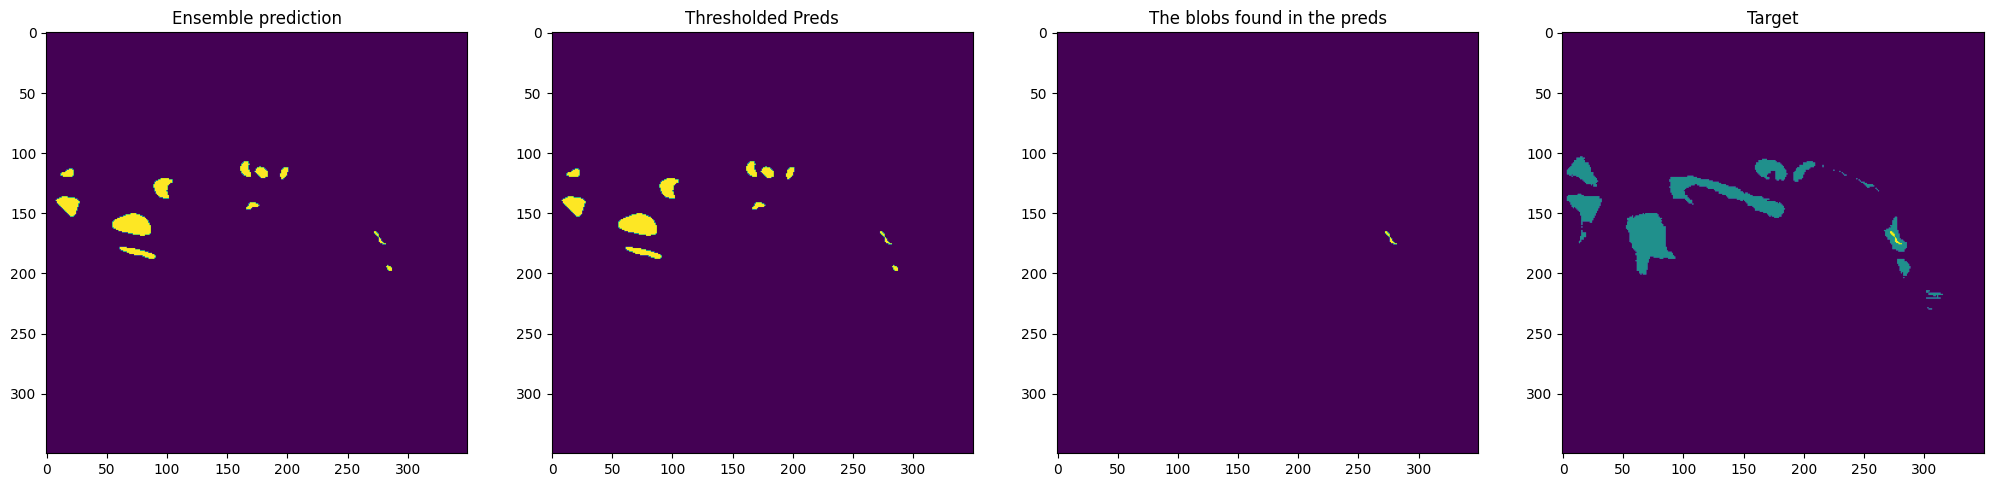

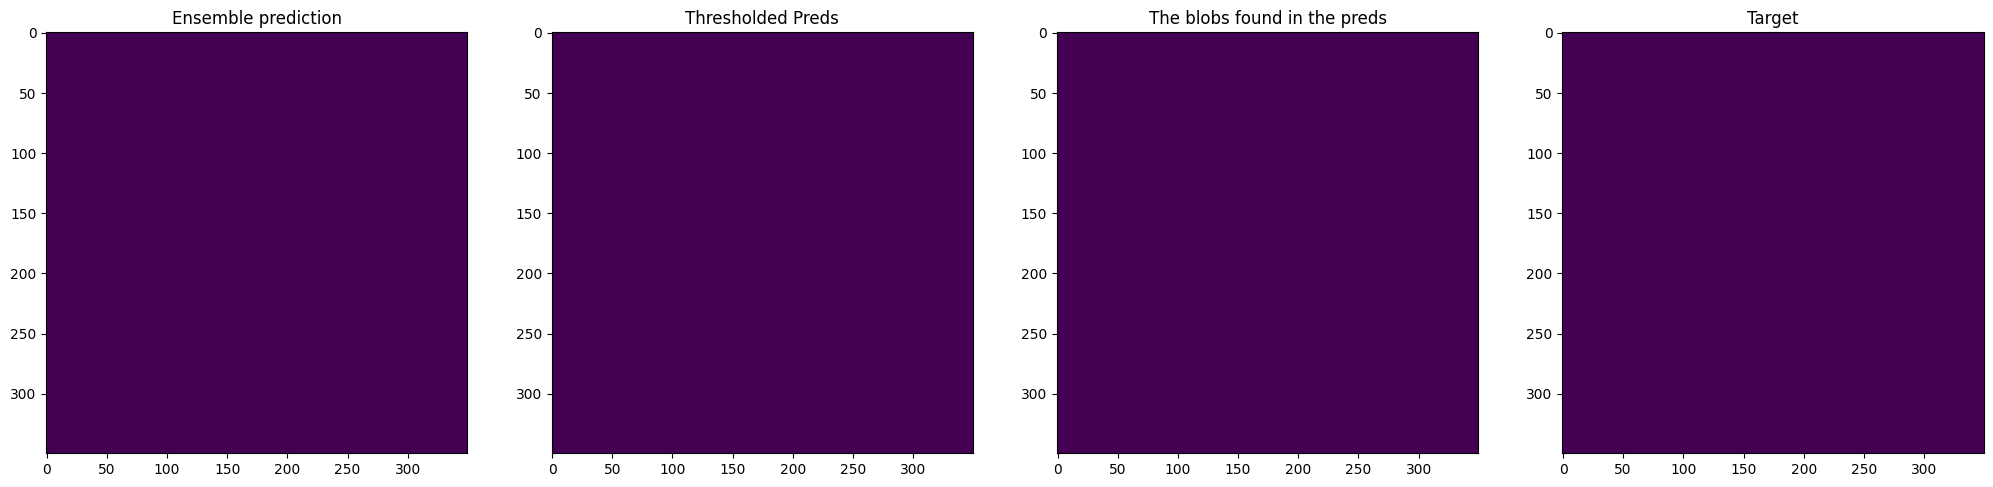

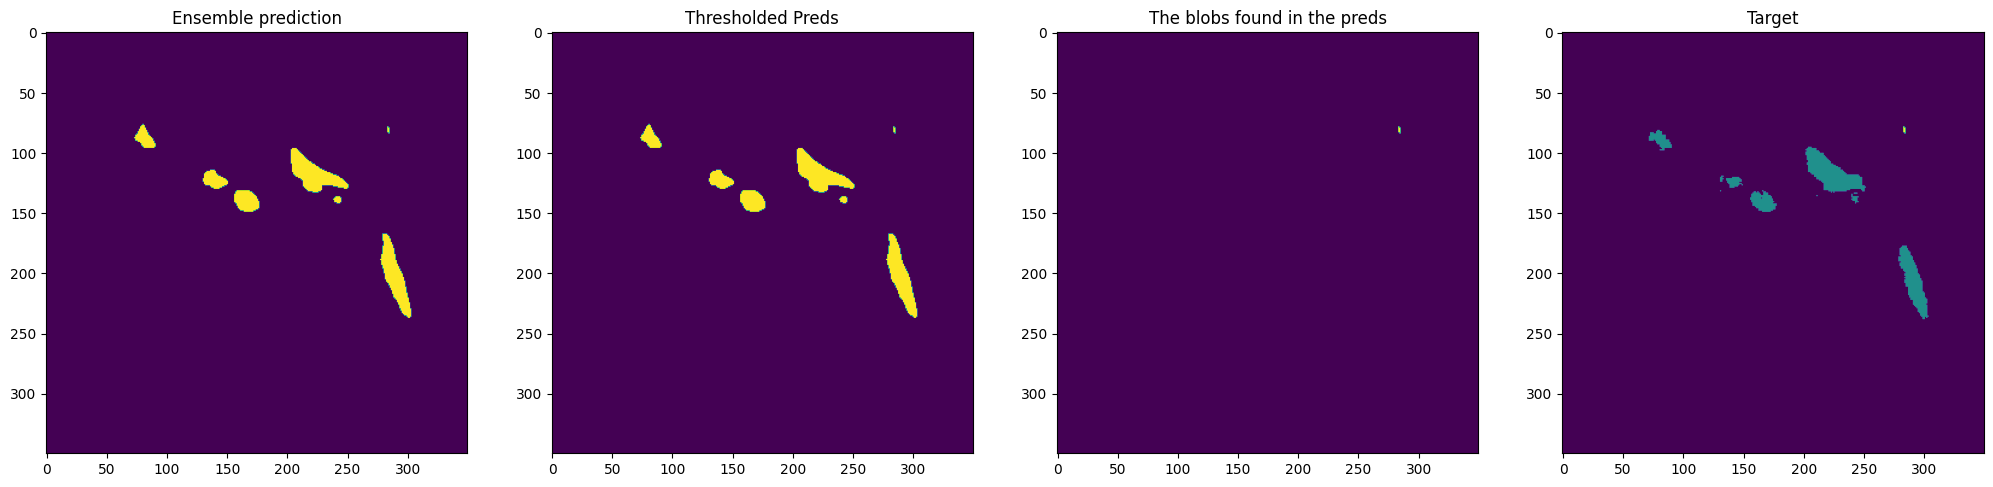

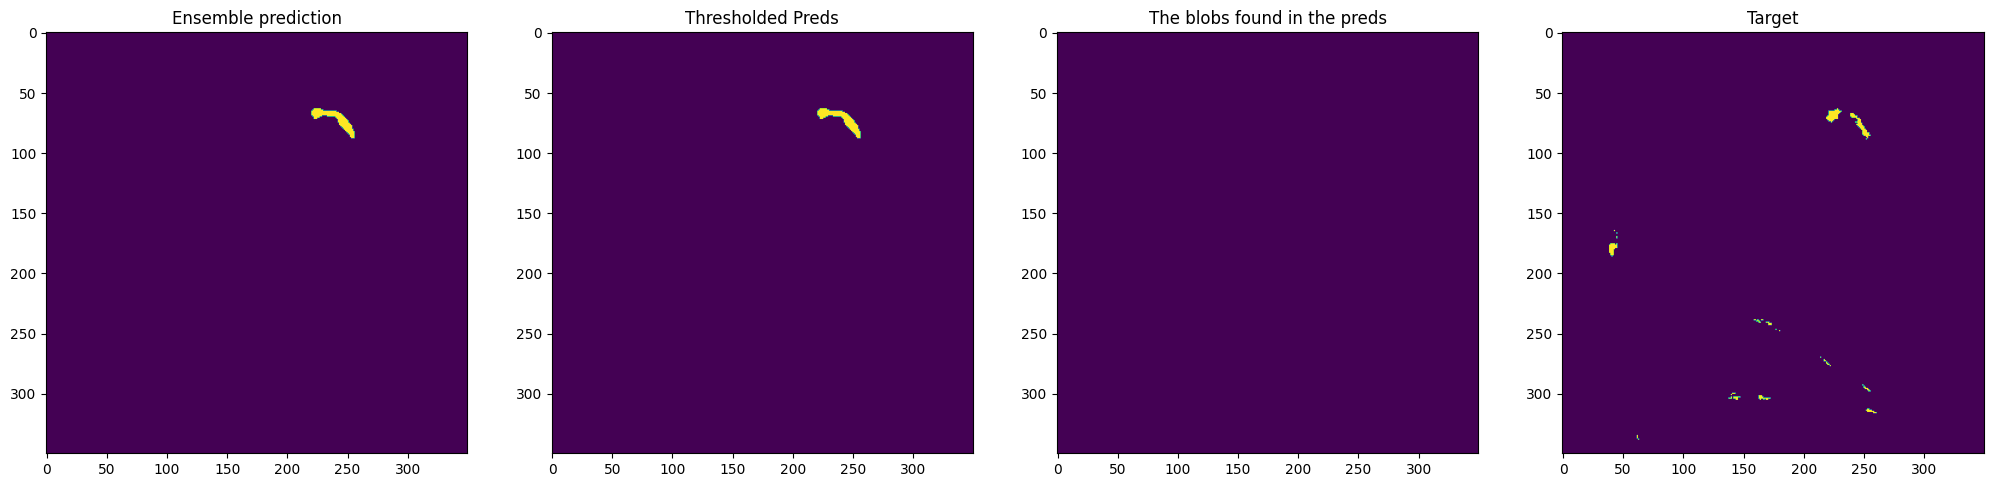

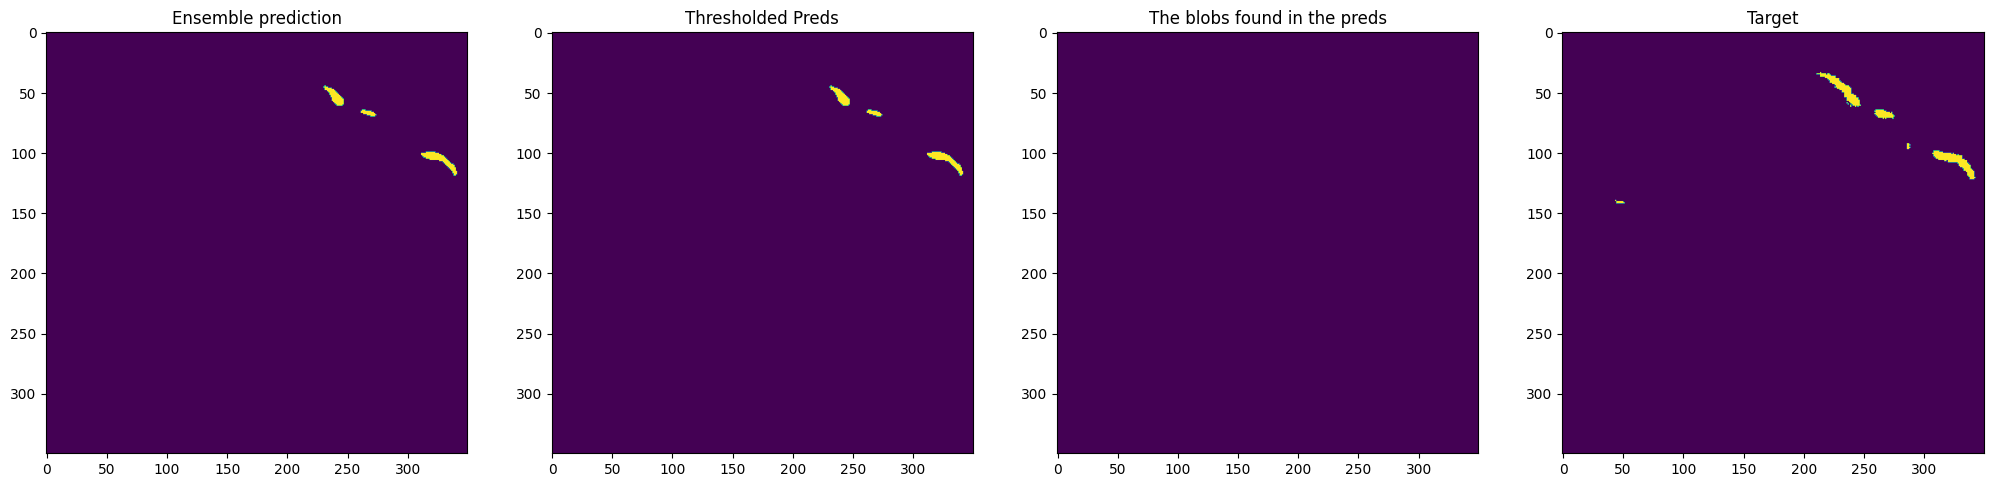

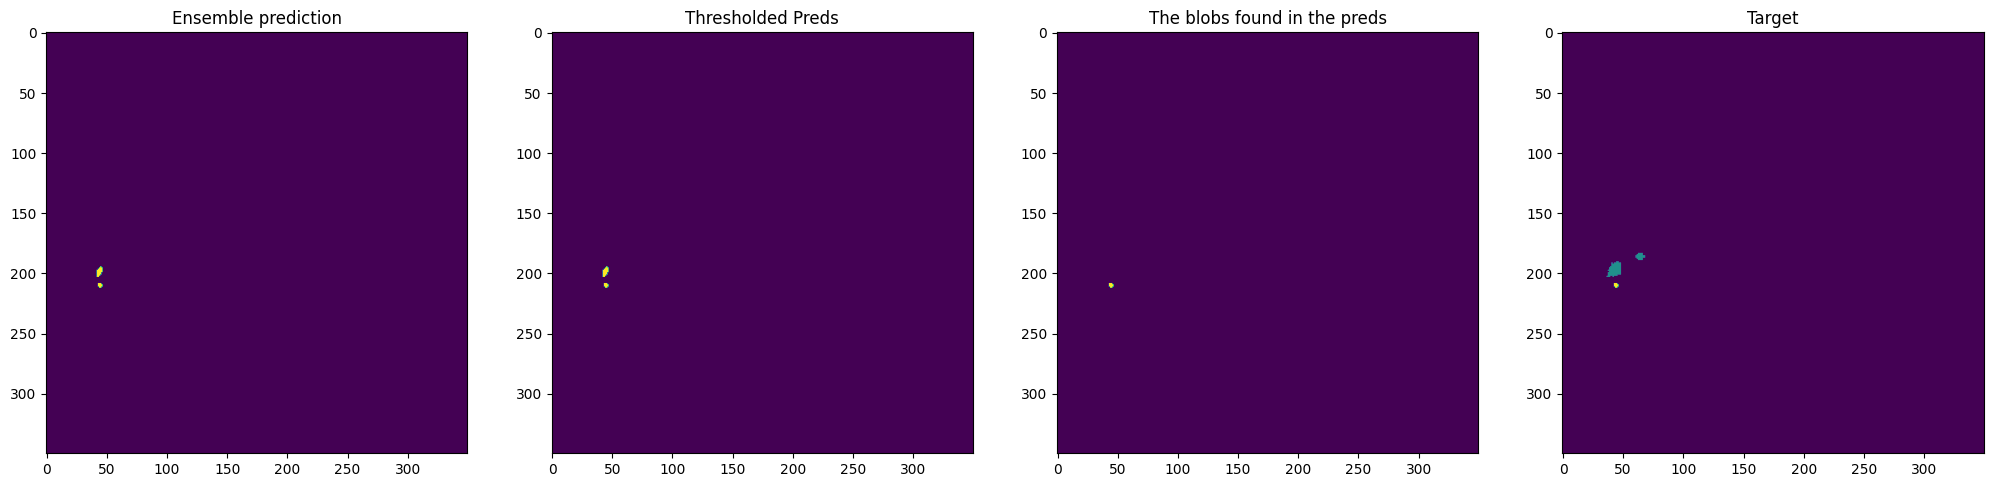

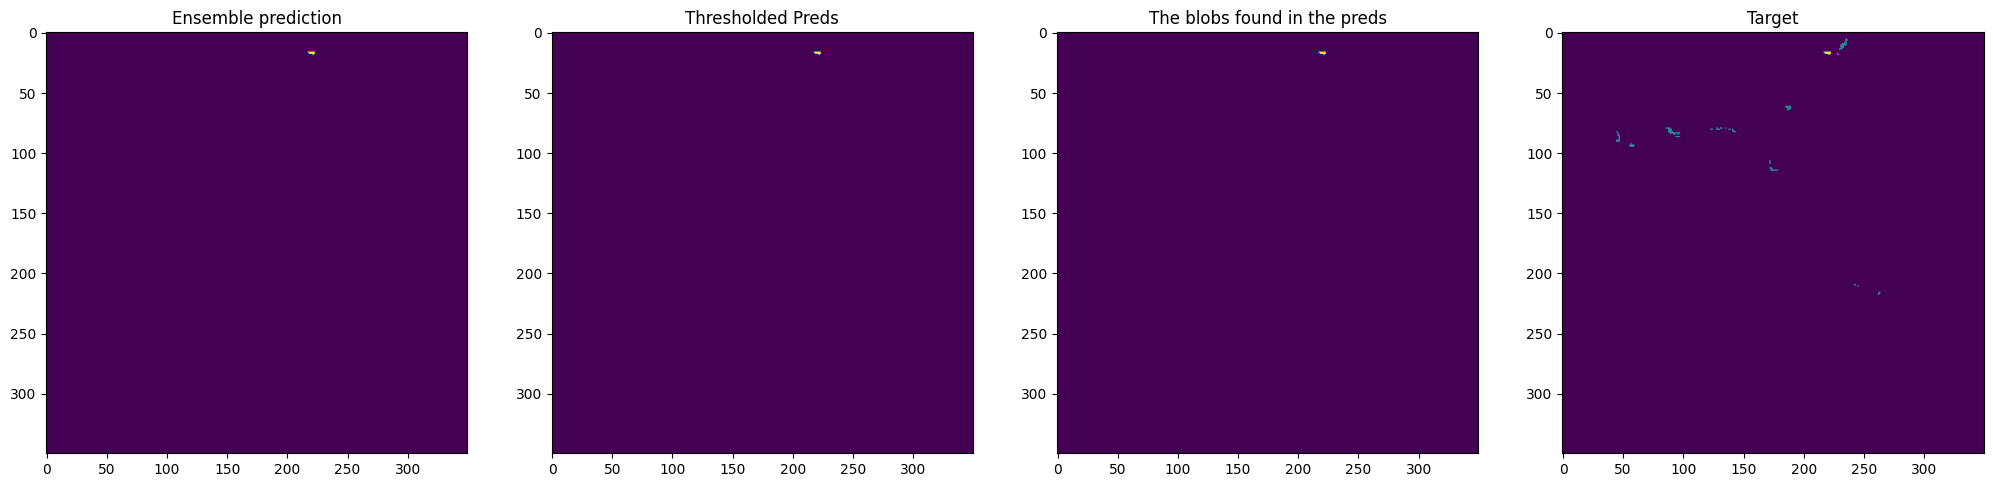

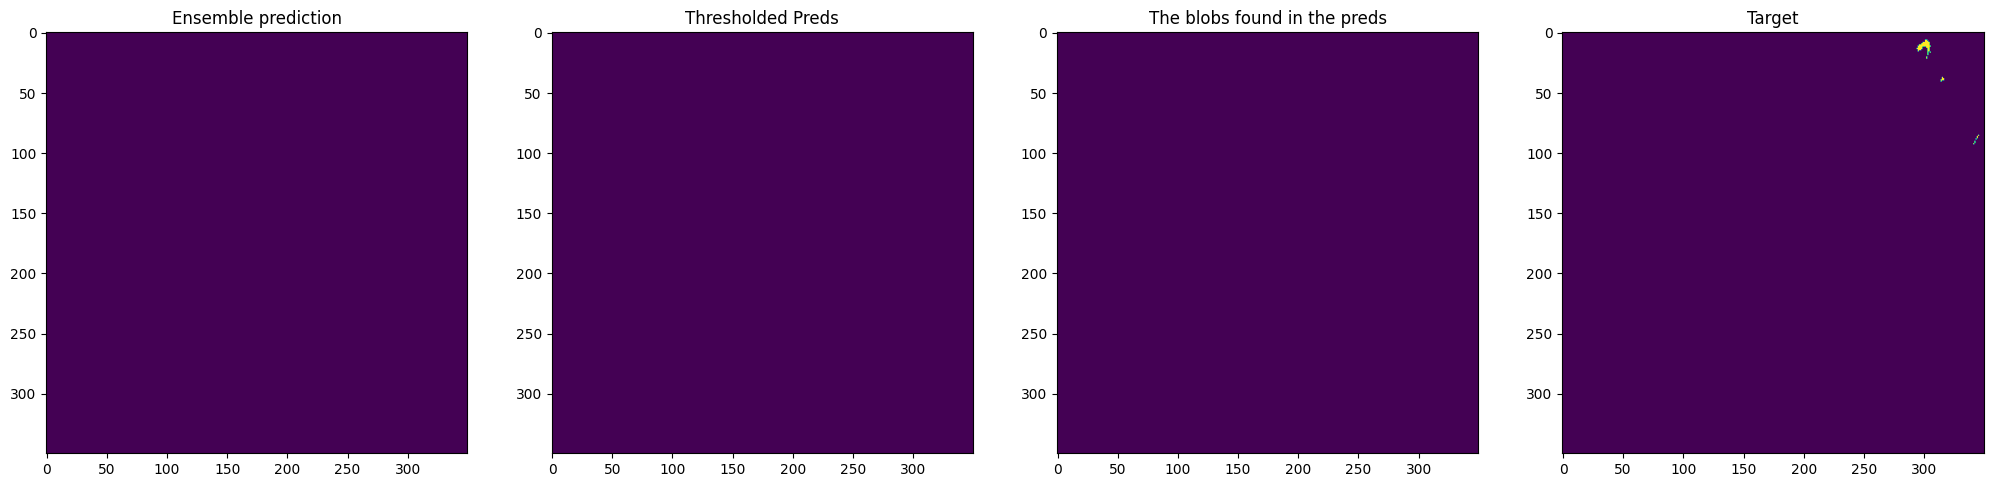

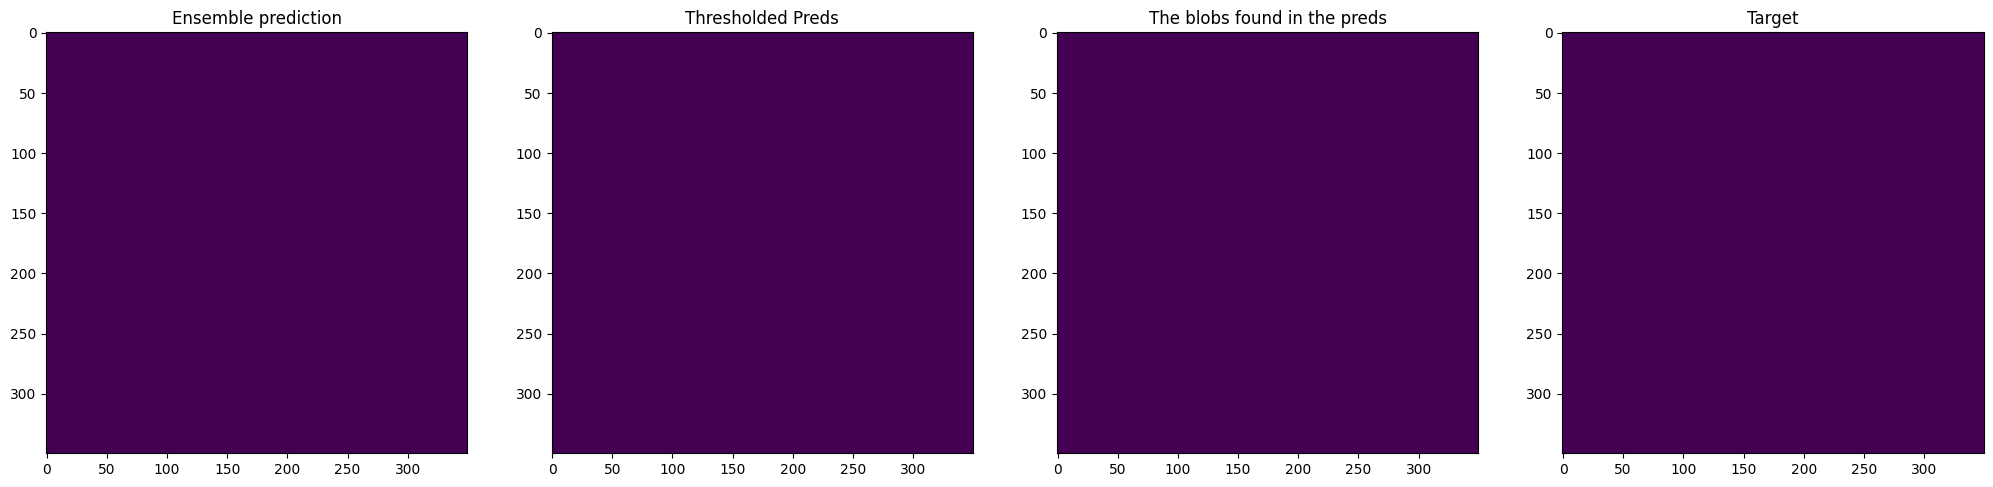

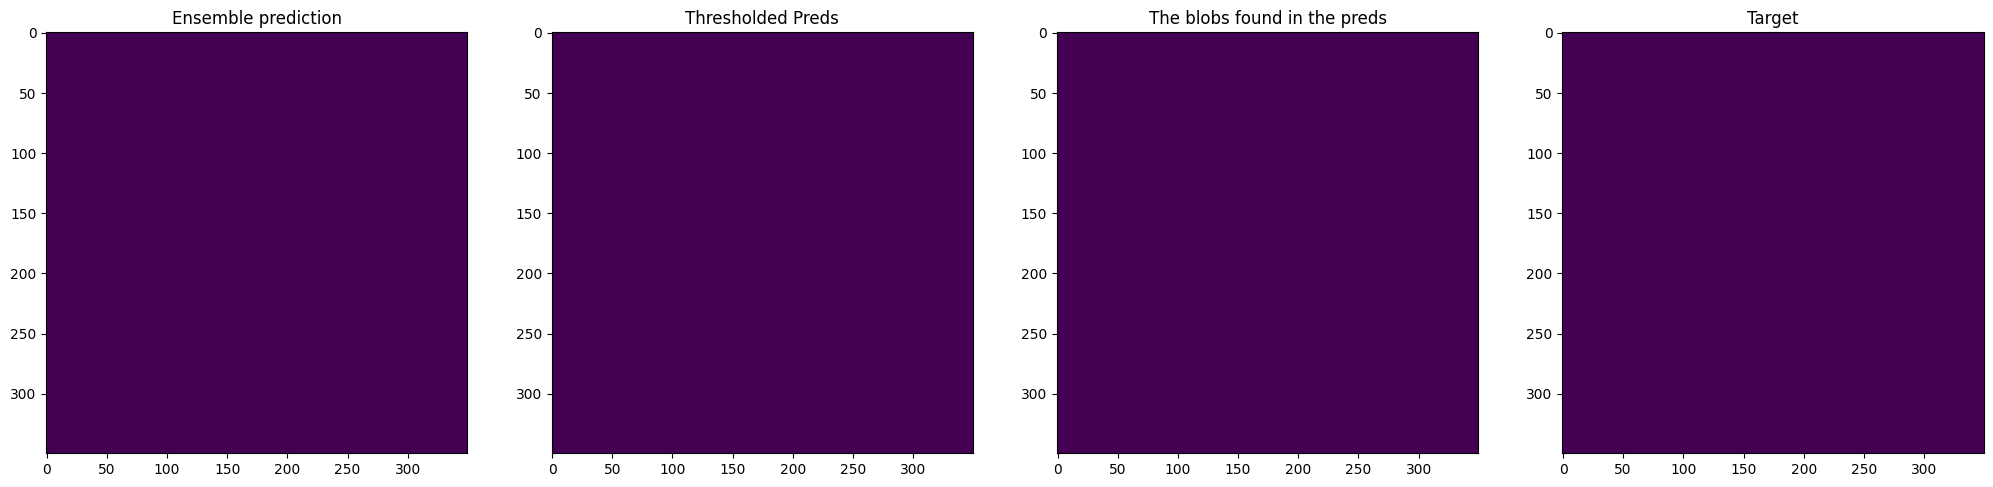

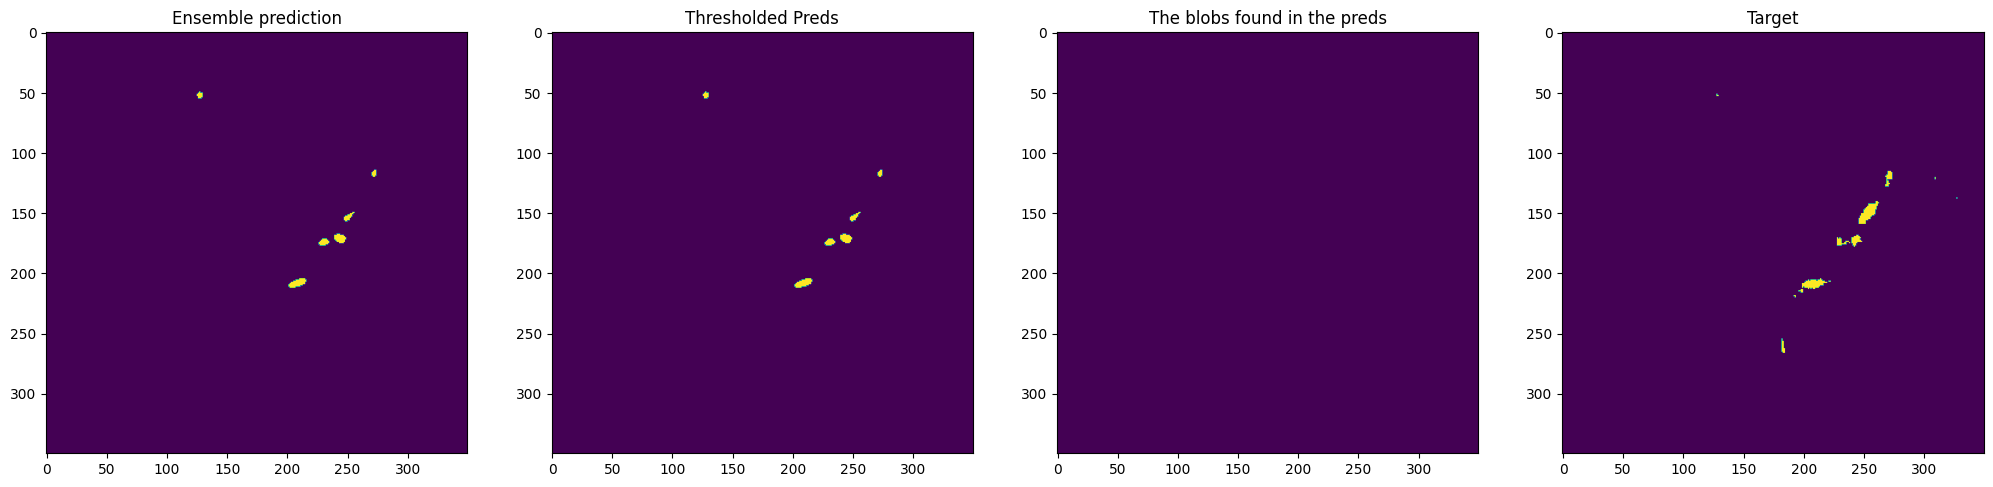

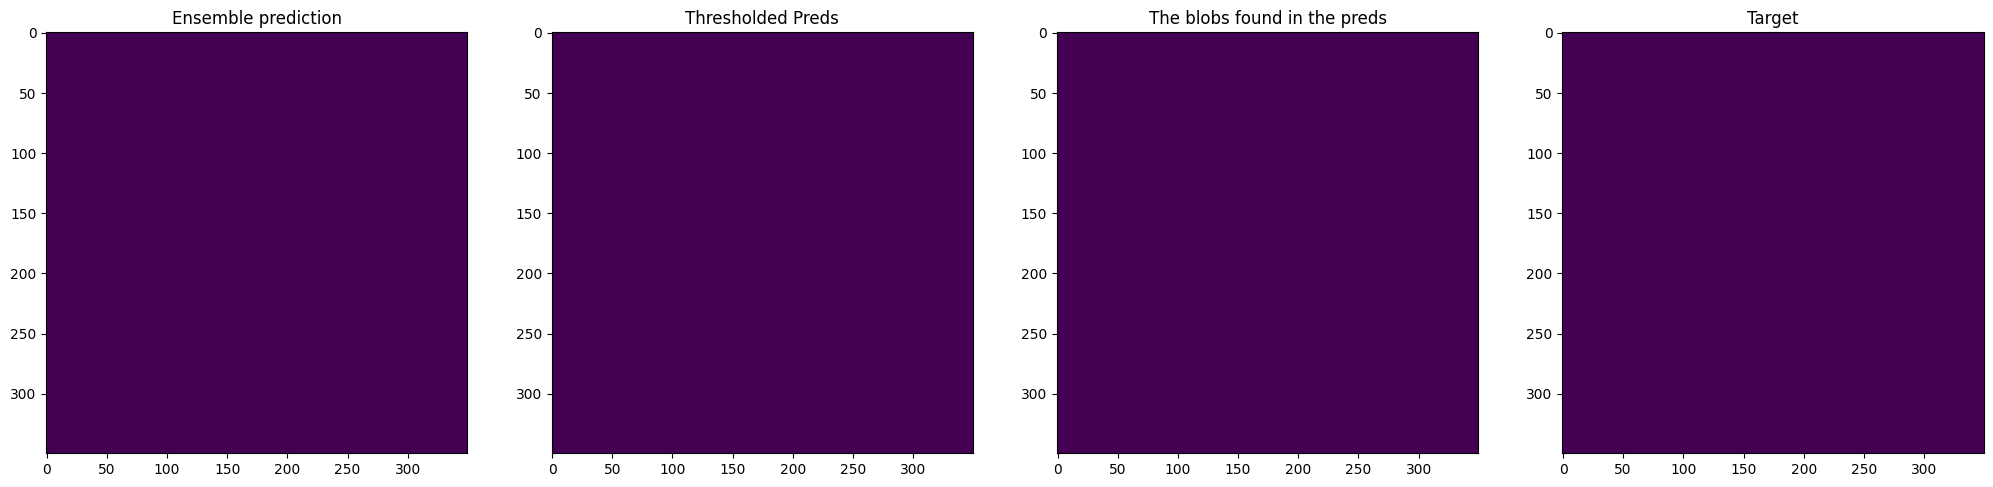

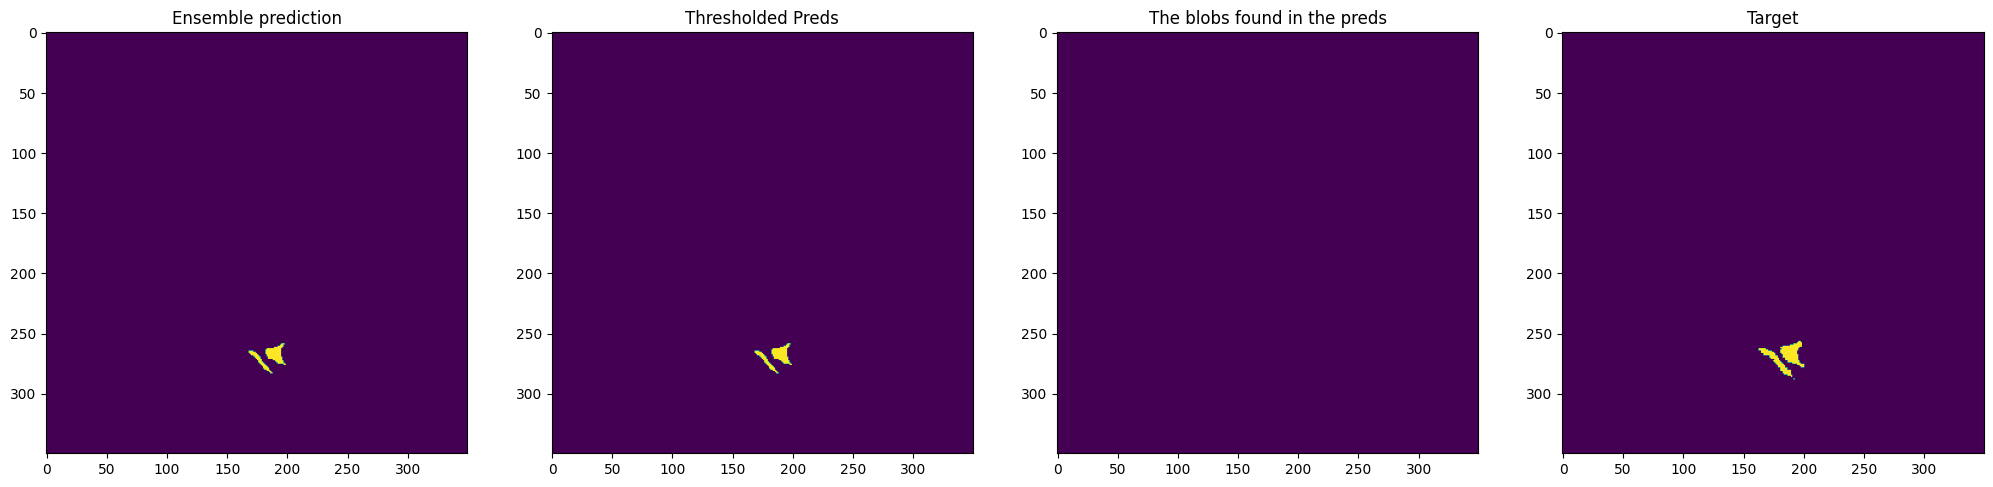

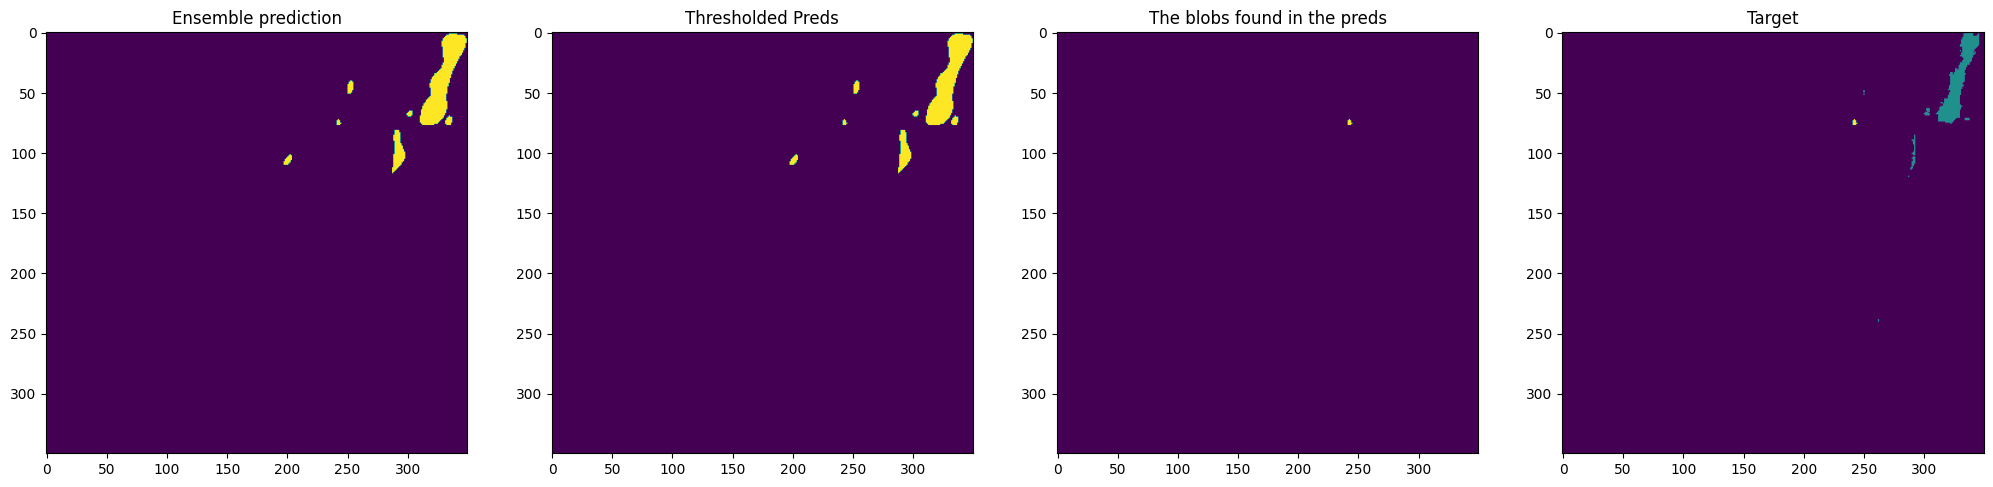

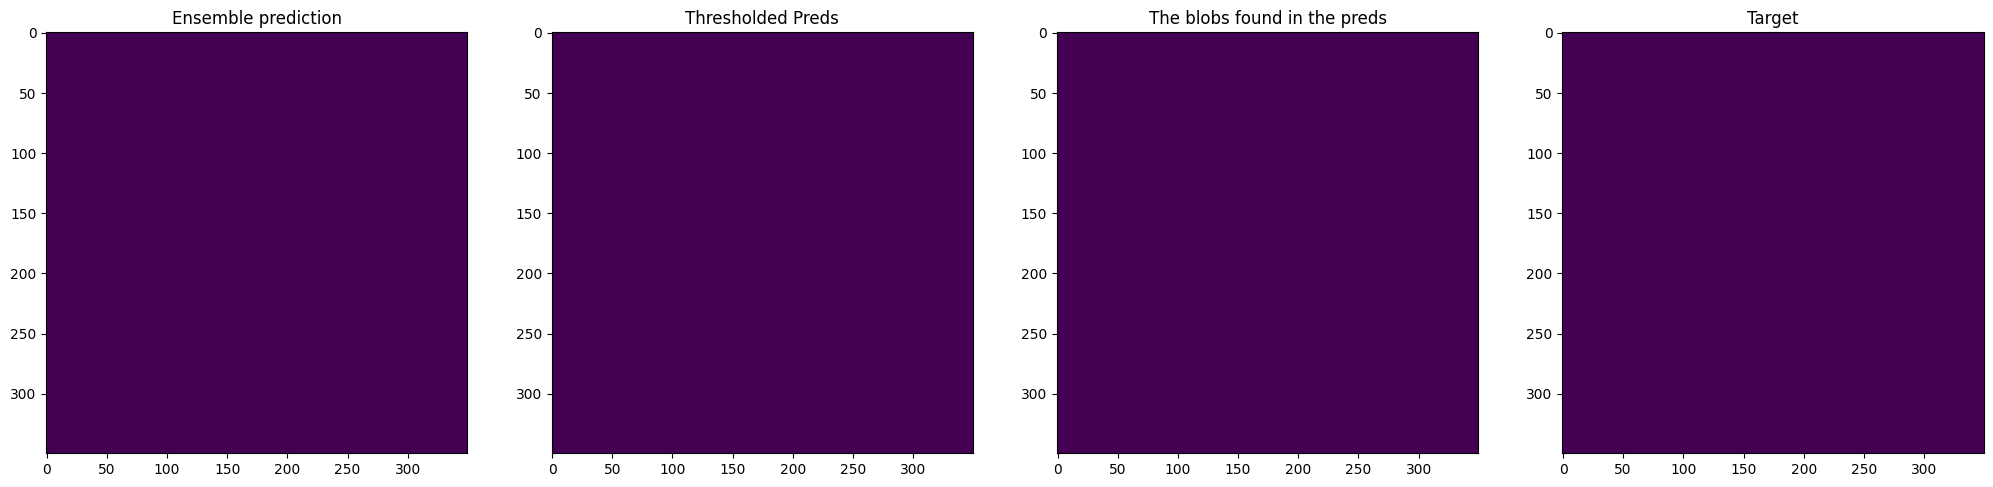

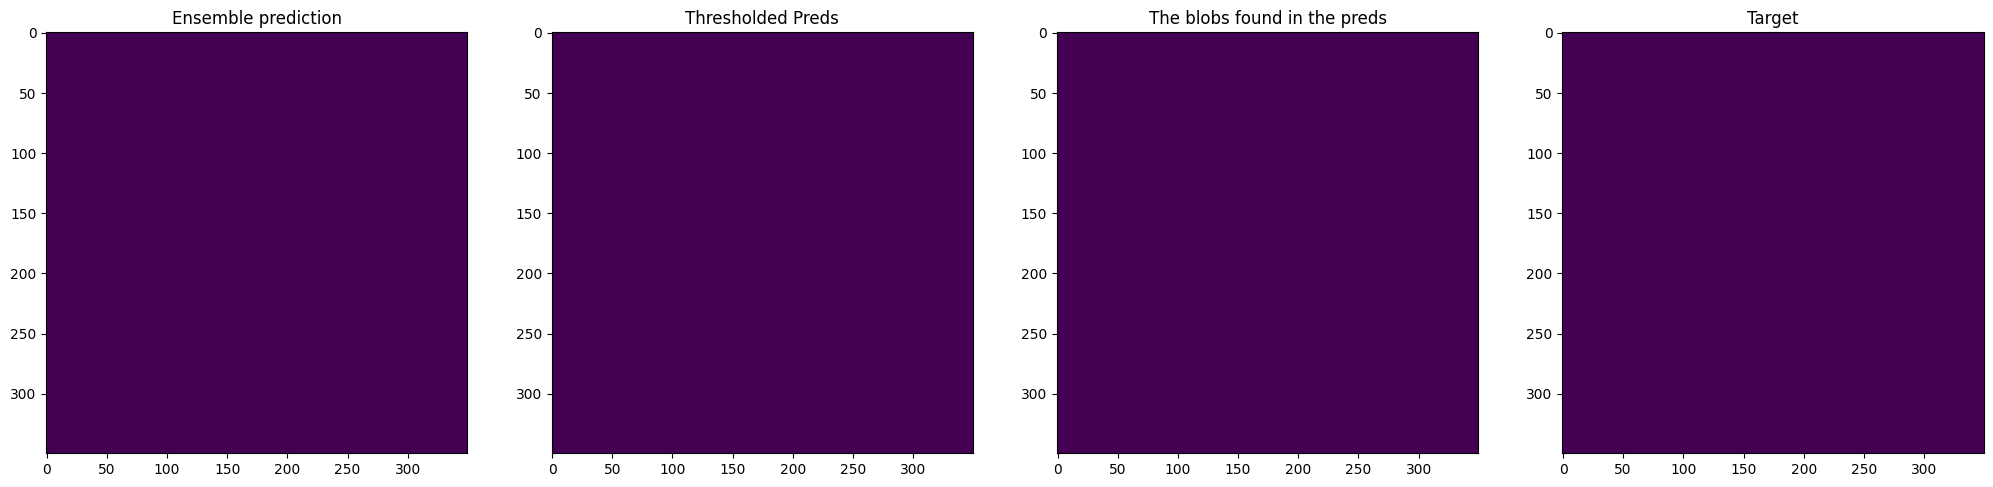

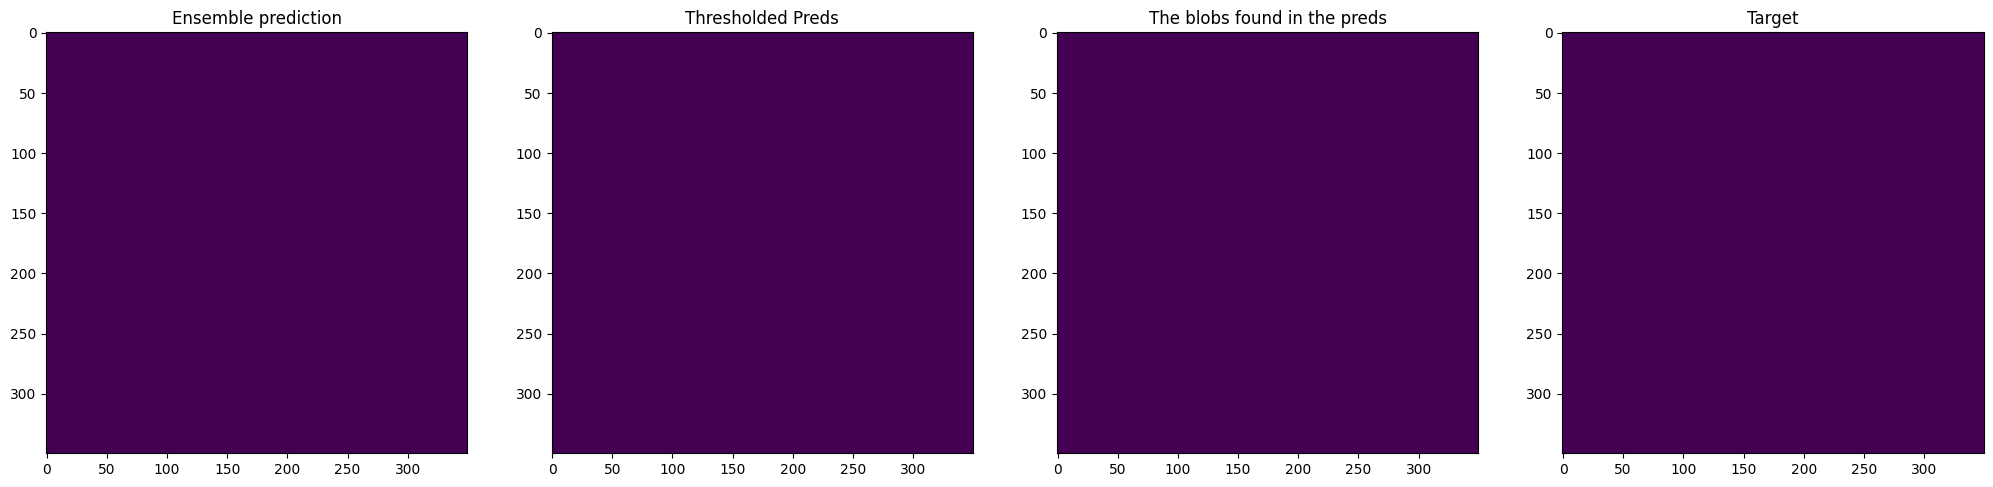

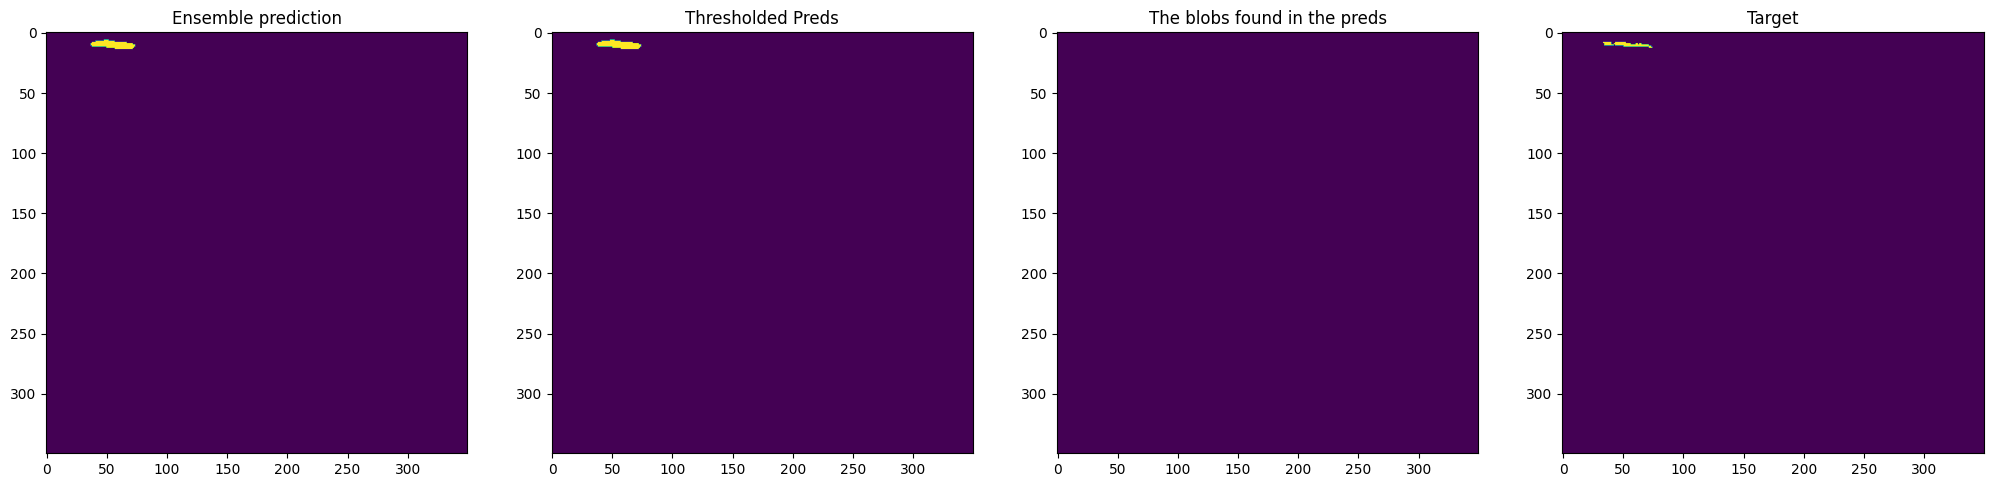

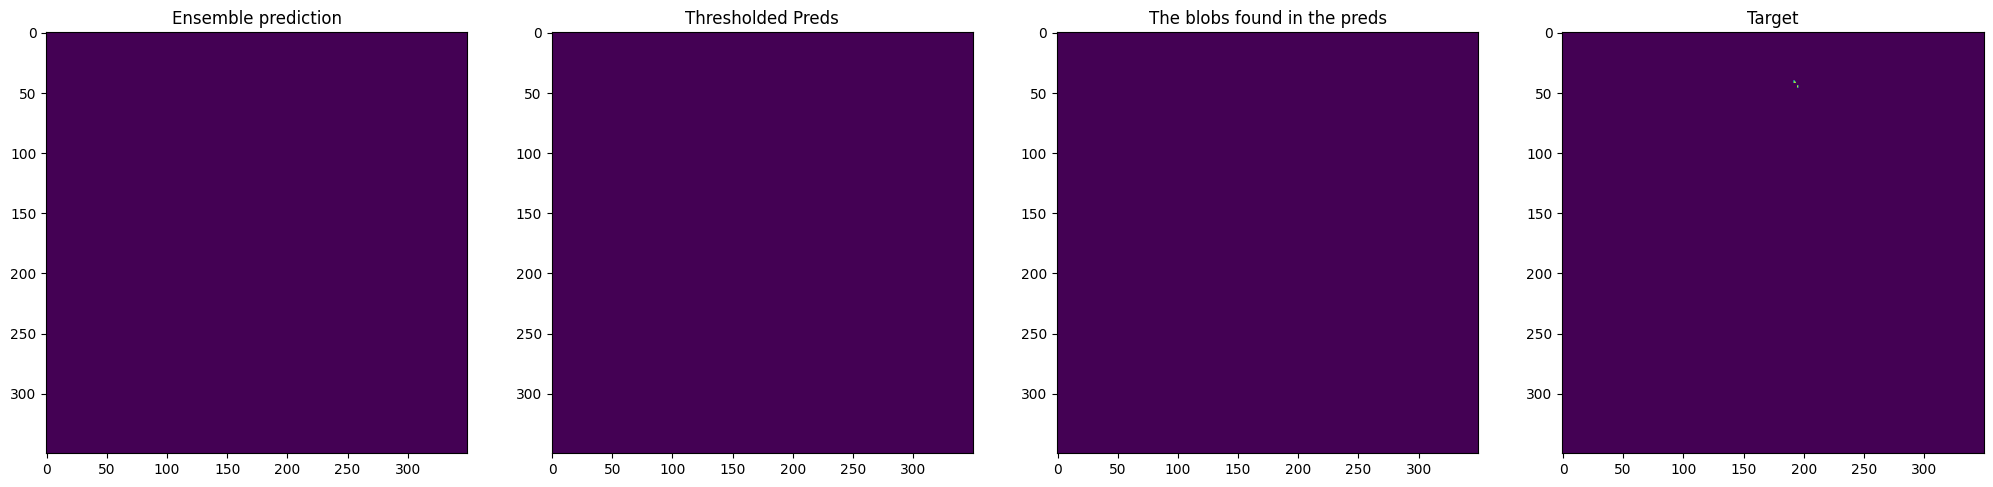

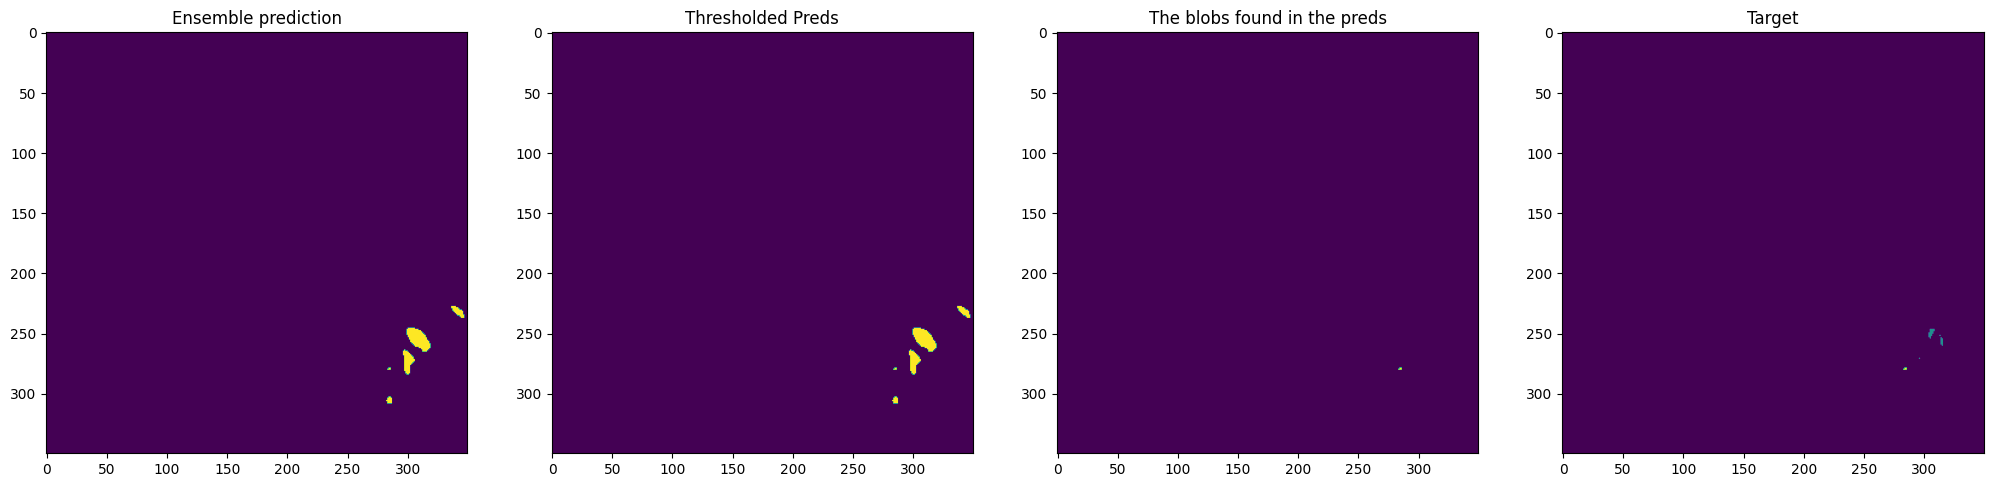

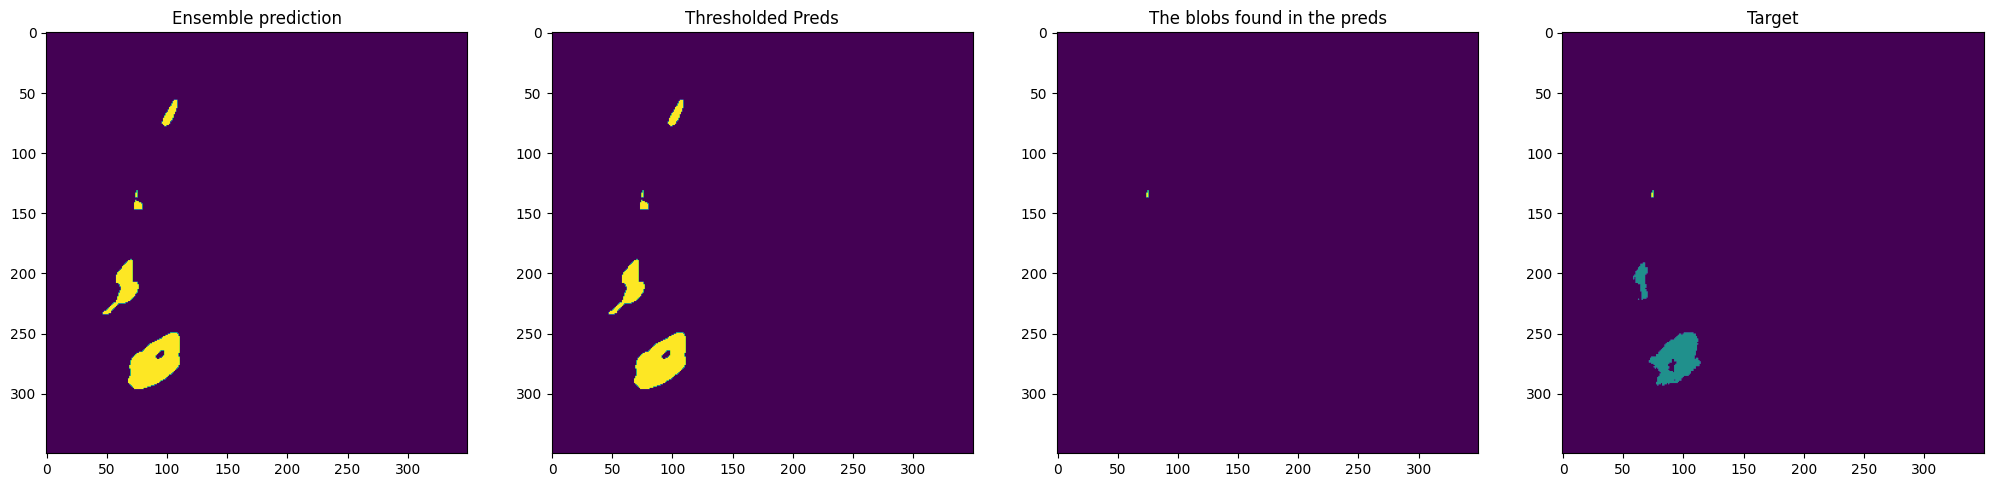

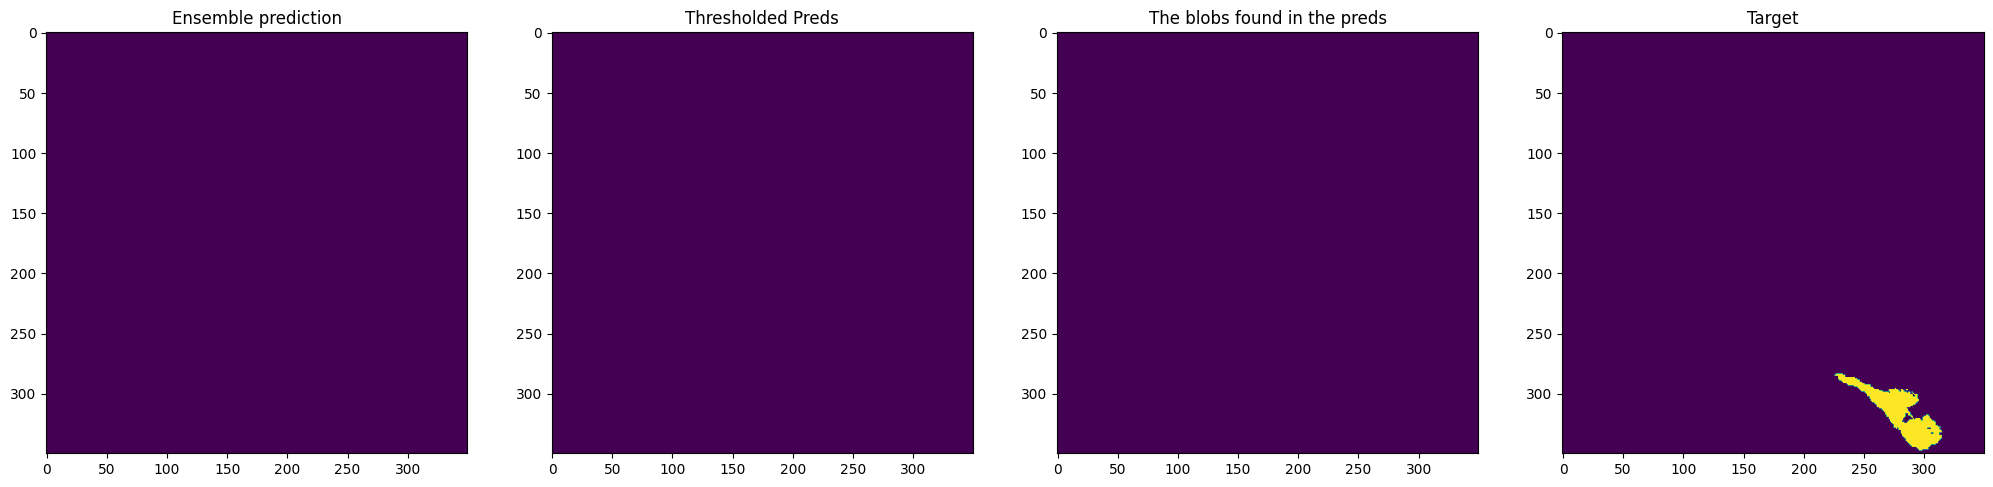

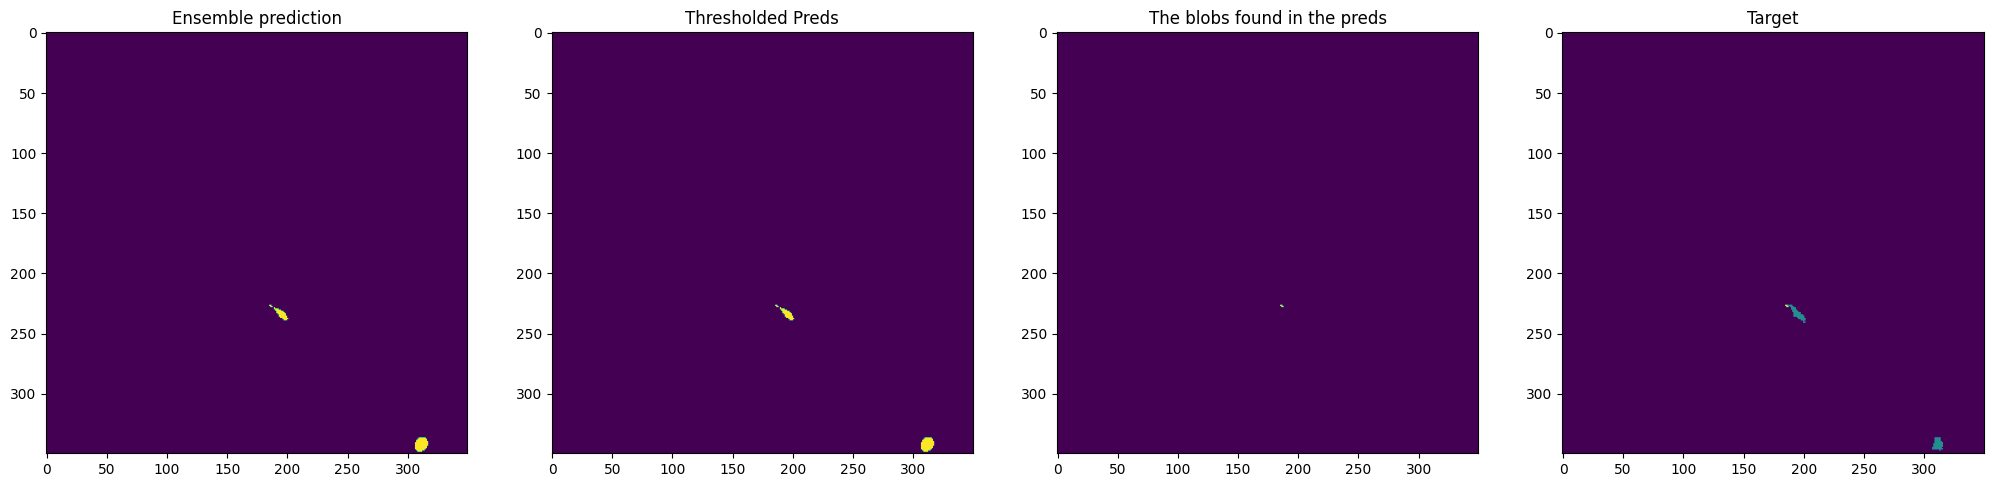

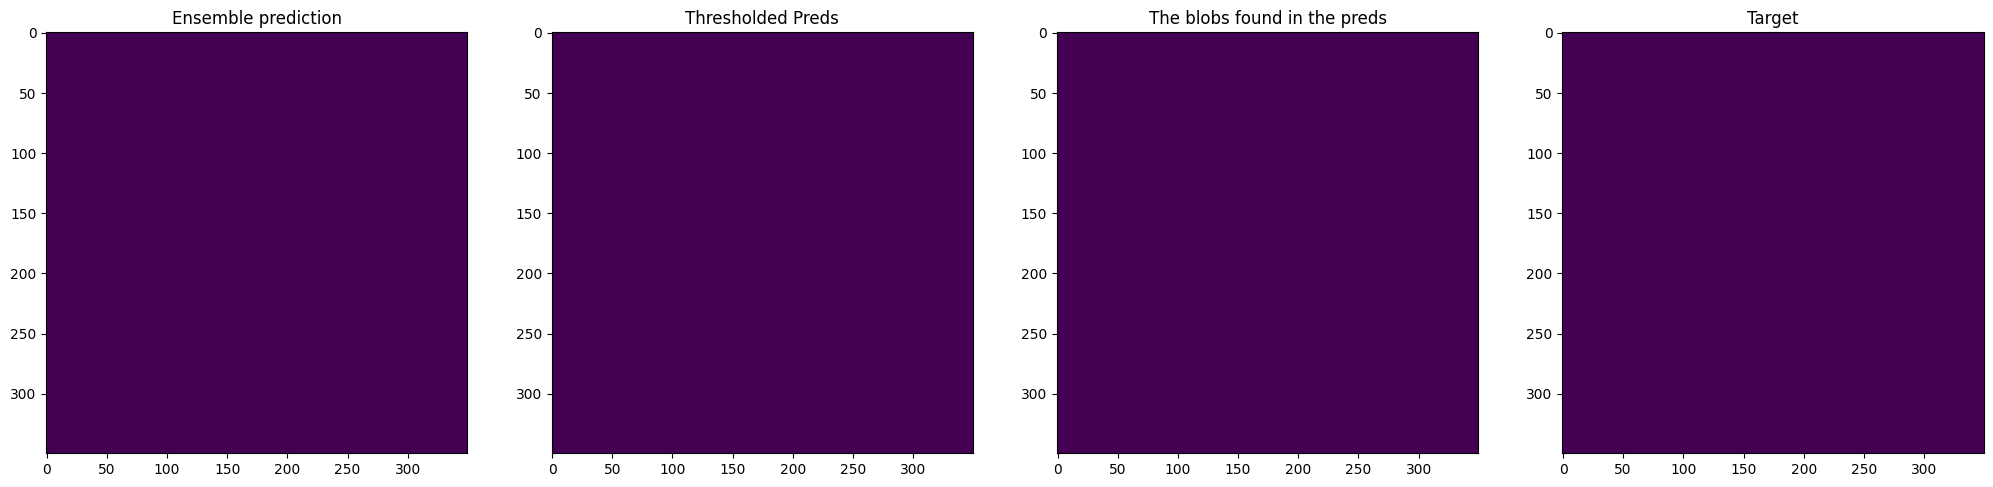

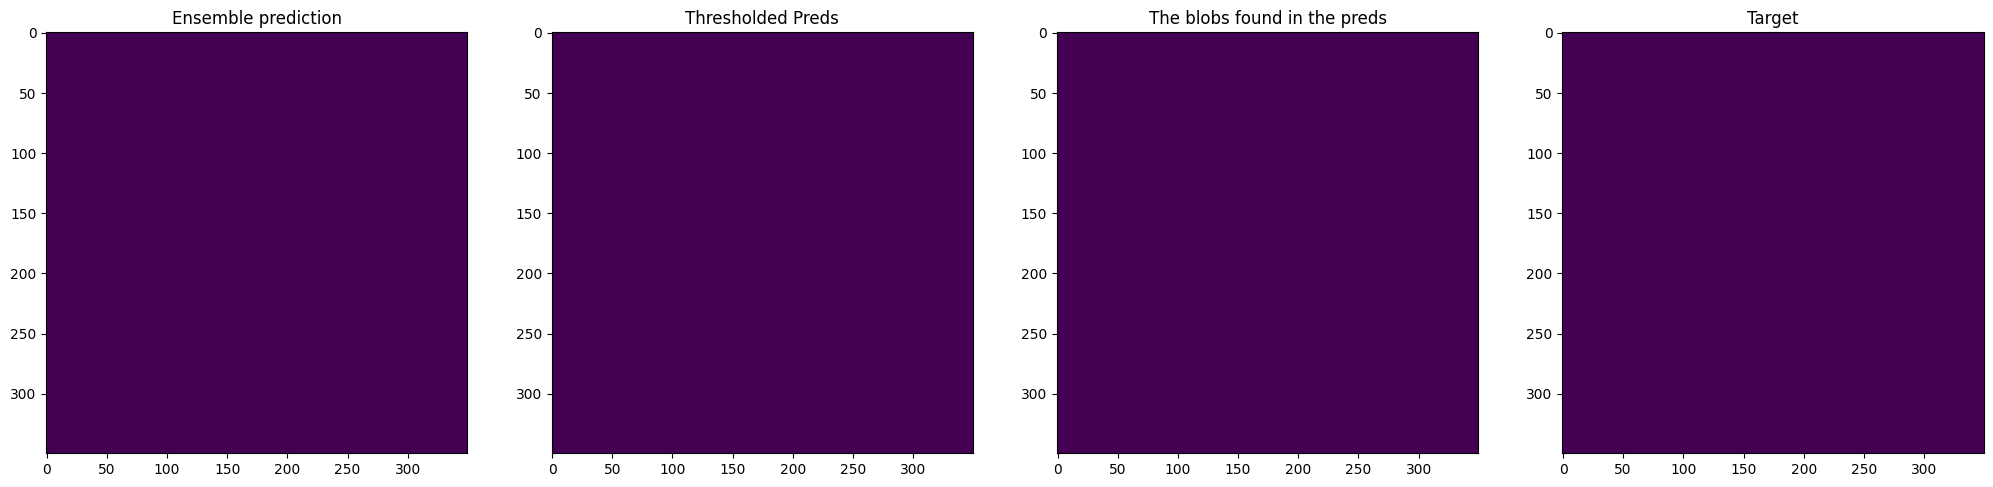

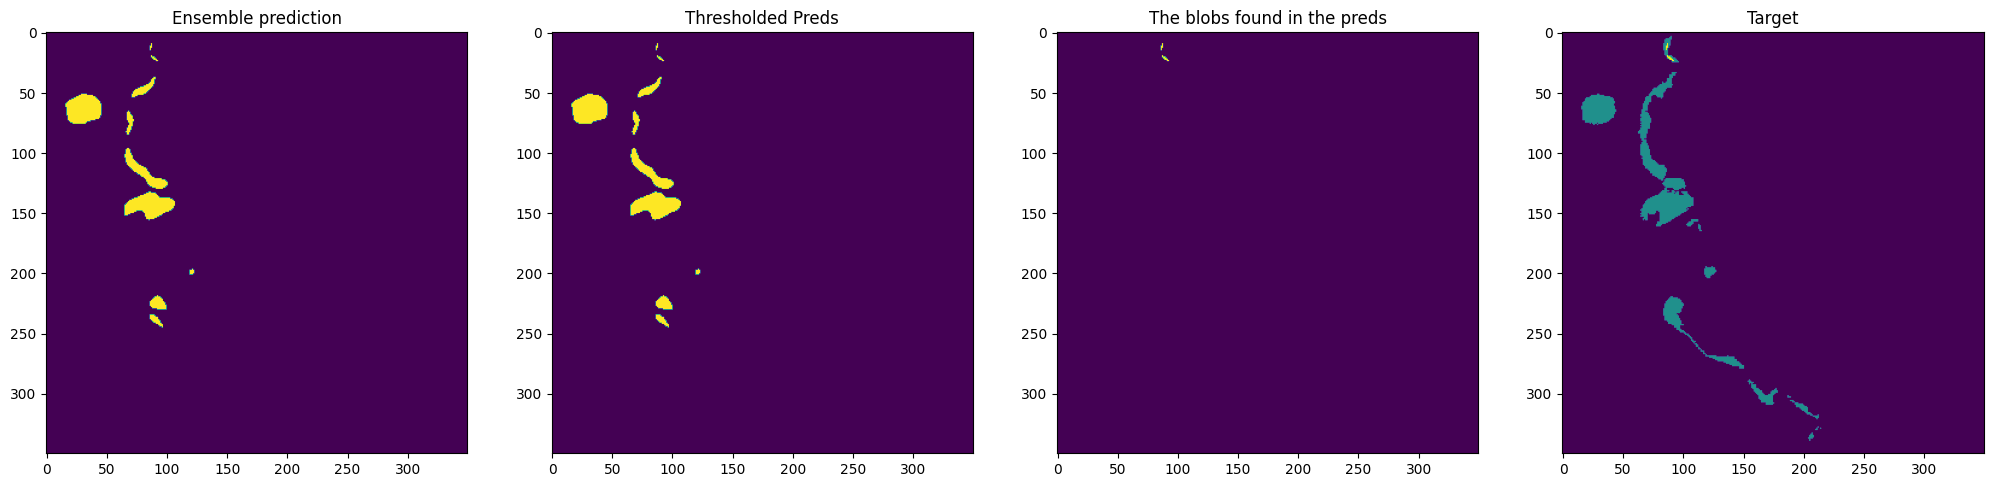

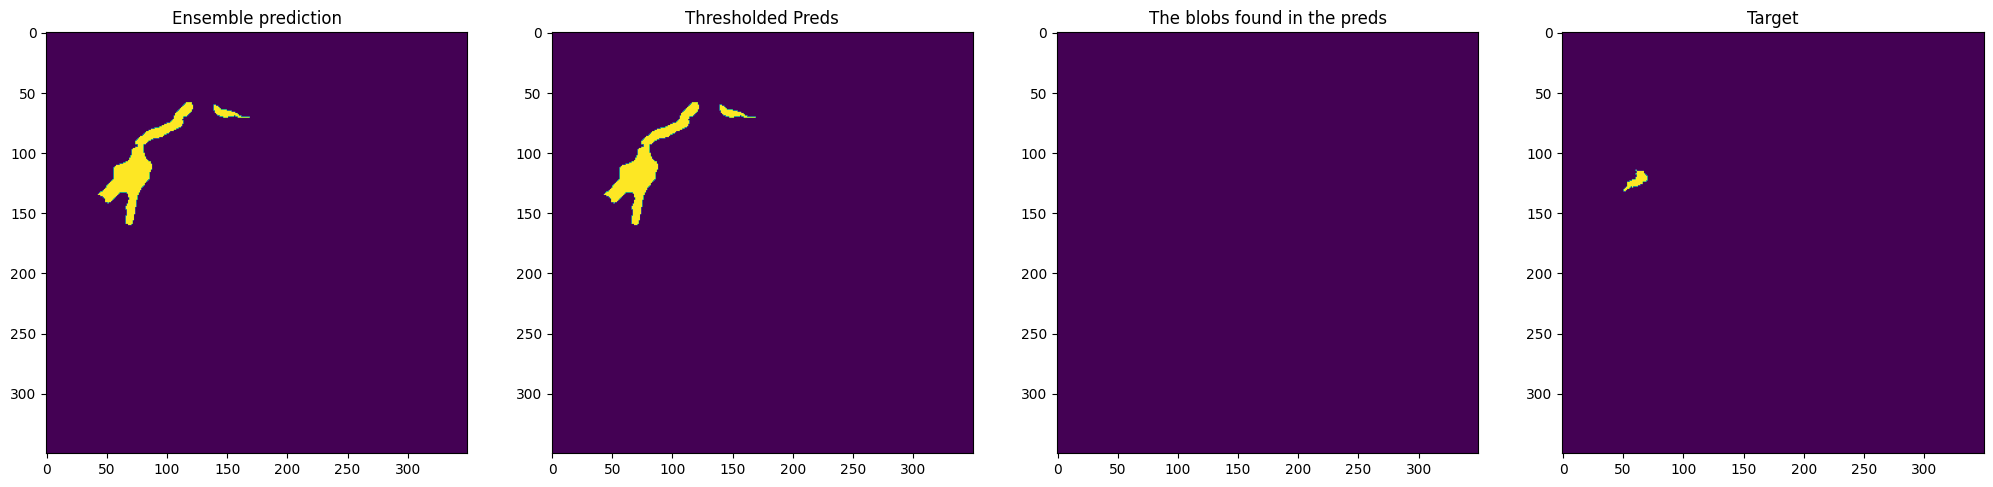

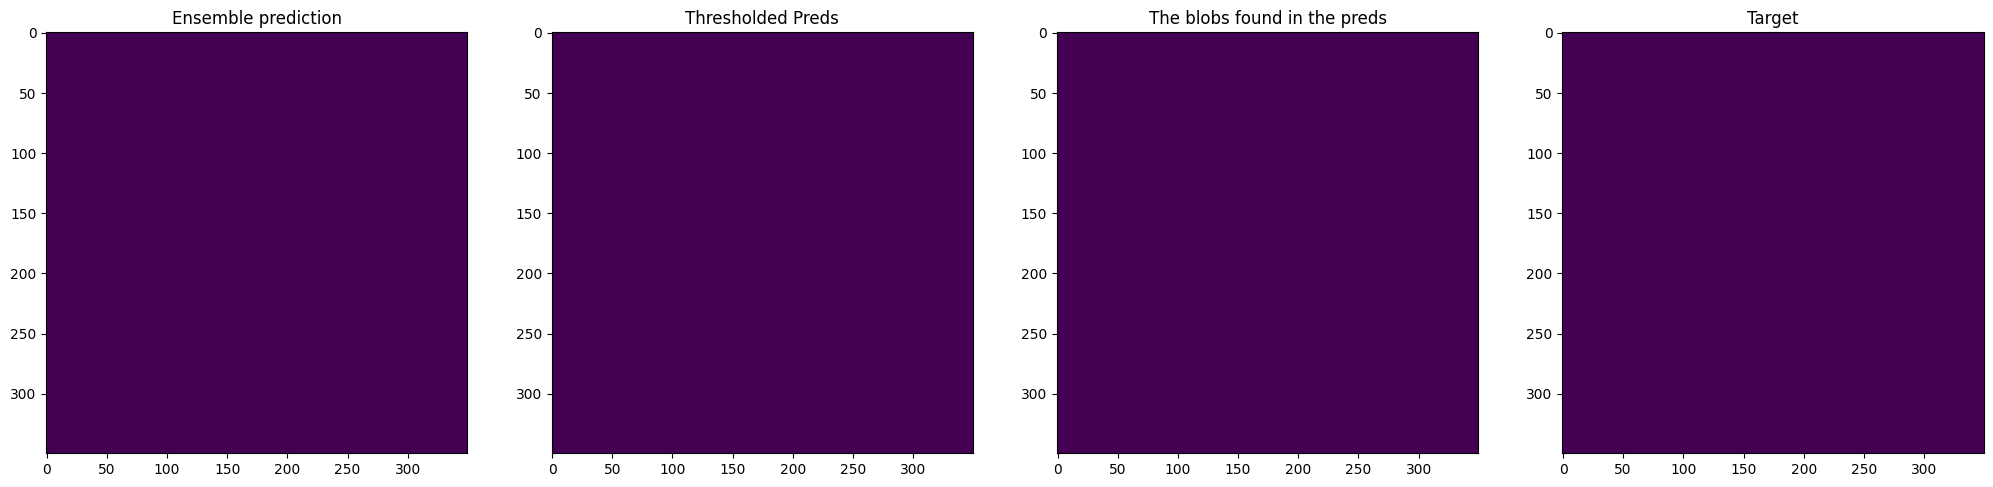

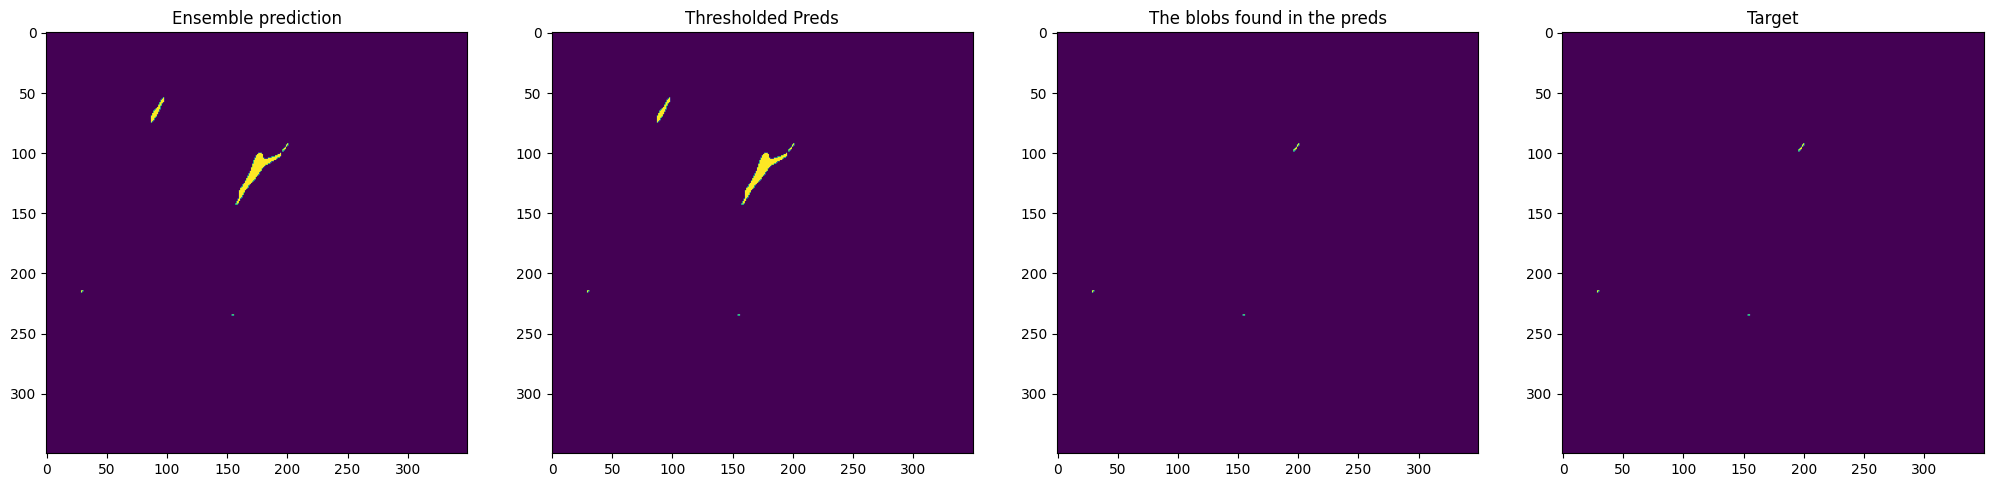

In [ ]:
# Now plot all the 3 things plotted above in a single figure

for n in range(50,55):
    fig, ax = plt.subplots(1, 4, figsize=(25, 10))
    ax[0].imshow(ensemble_preds[n])
    ax[0].set_title("Ensemble prediction")
    # plot the thresholded preds
    ensemble_preds = ensemble_preds > 0.5
    ax[1].imshow(ensemble_preds[n])
    ax[1].set_title("Thresholded Preds")
    ax[2].imshow(blobs[n])
    ax[2].set_title("The blobs found in the preds")
    # also include the labels but amplify the points where the blobs are found
    reshaped_targets = reshaped_targets.astype(float)
    reshaped_targets[blobs == 1] = 2
    ax[3].imshow(reshaped_targets[n])
    ax[3].set_title("Target")
    plt.show()

    

In [103]:

# `binary_mask` now contains 1s for blobs with <= 15 pixels and 0s for all other areas
# Given this mask apply dilation to the predictions after thresholding to where the small blobs are to enhance them
from skimage.morphology import binary_dilation, disk
# apply dilation to the images in the blobs array
dilated_blobs = np.zeros_like(blobs)
for i in range(blobs.shape[0]):
    dilated_blobs[i] = binary_dilation(blobs[i], disk(2))



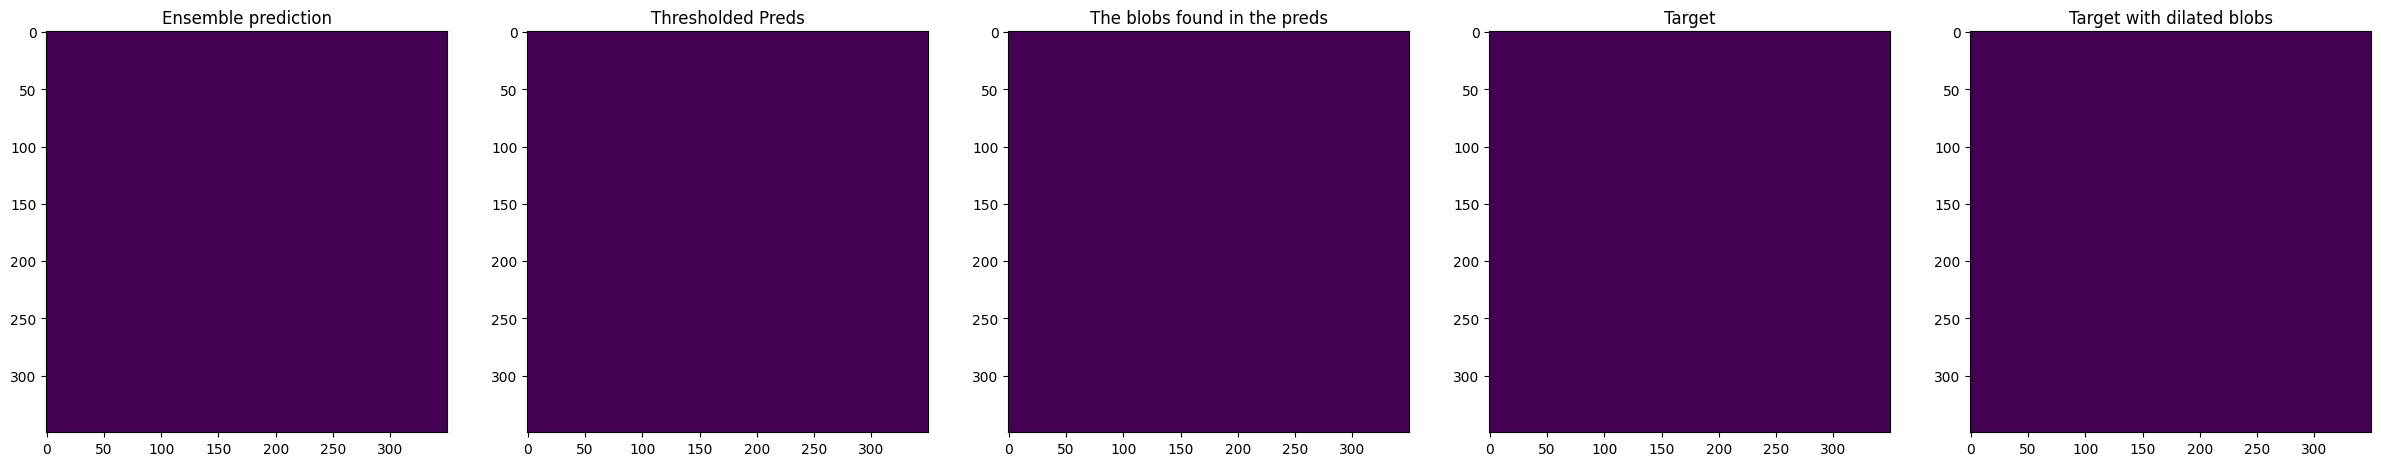

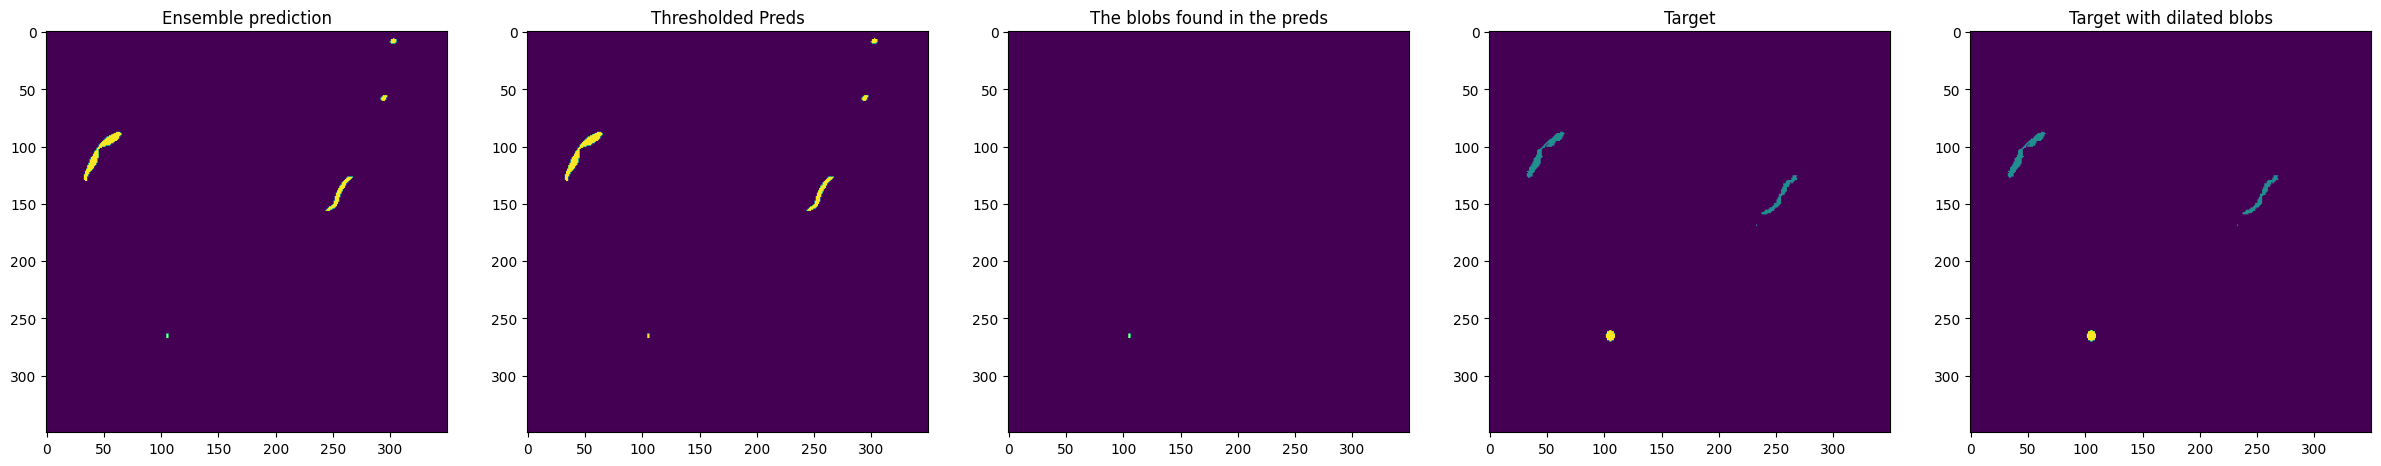

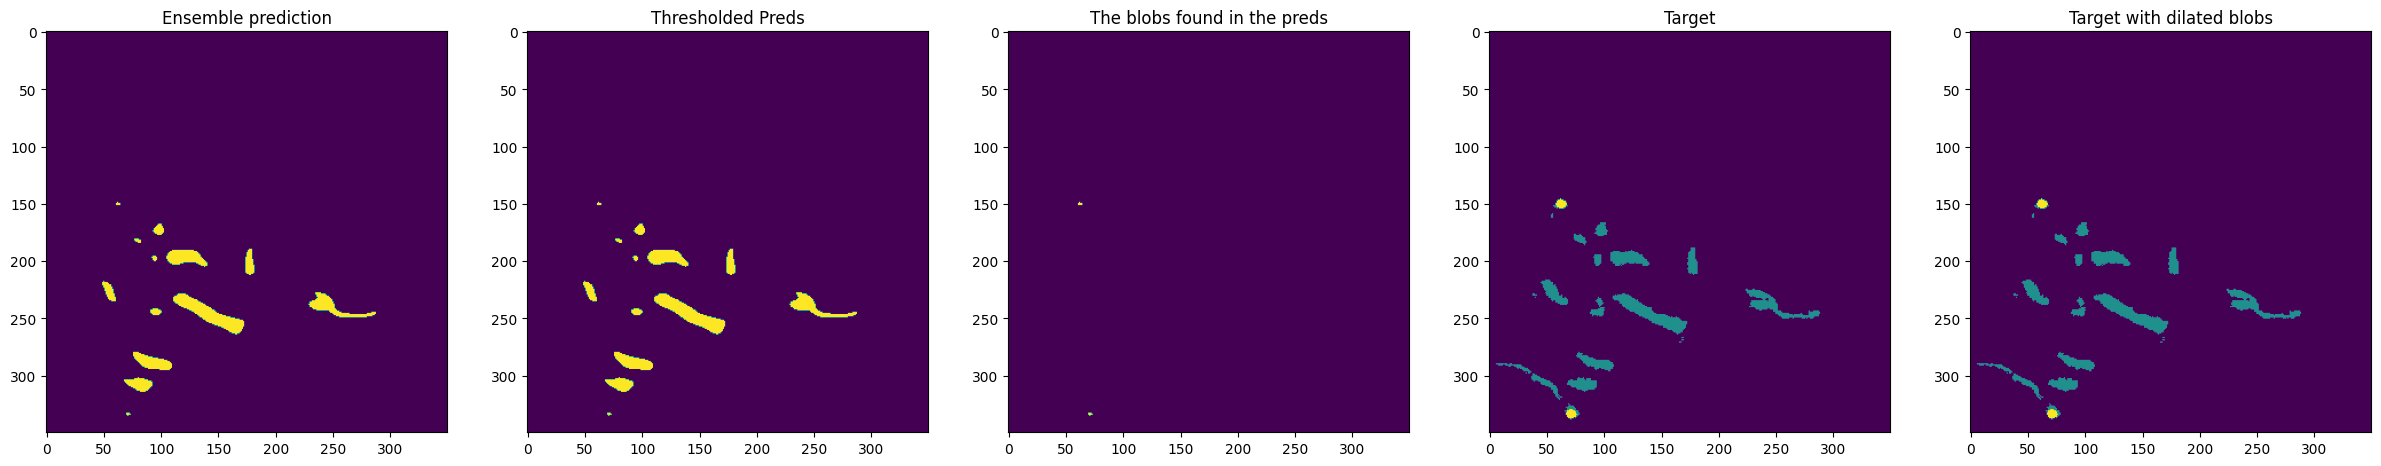

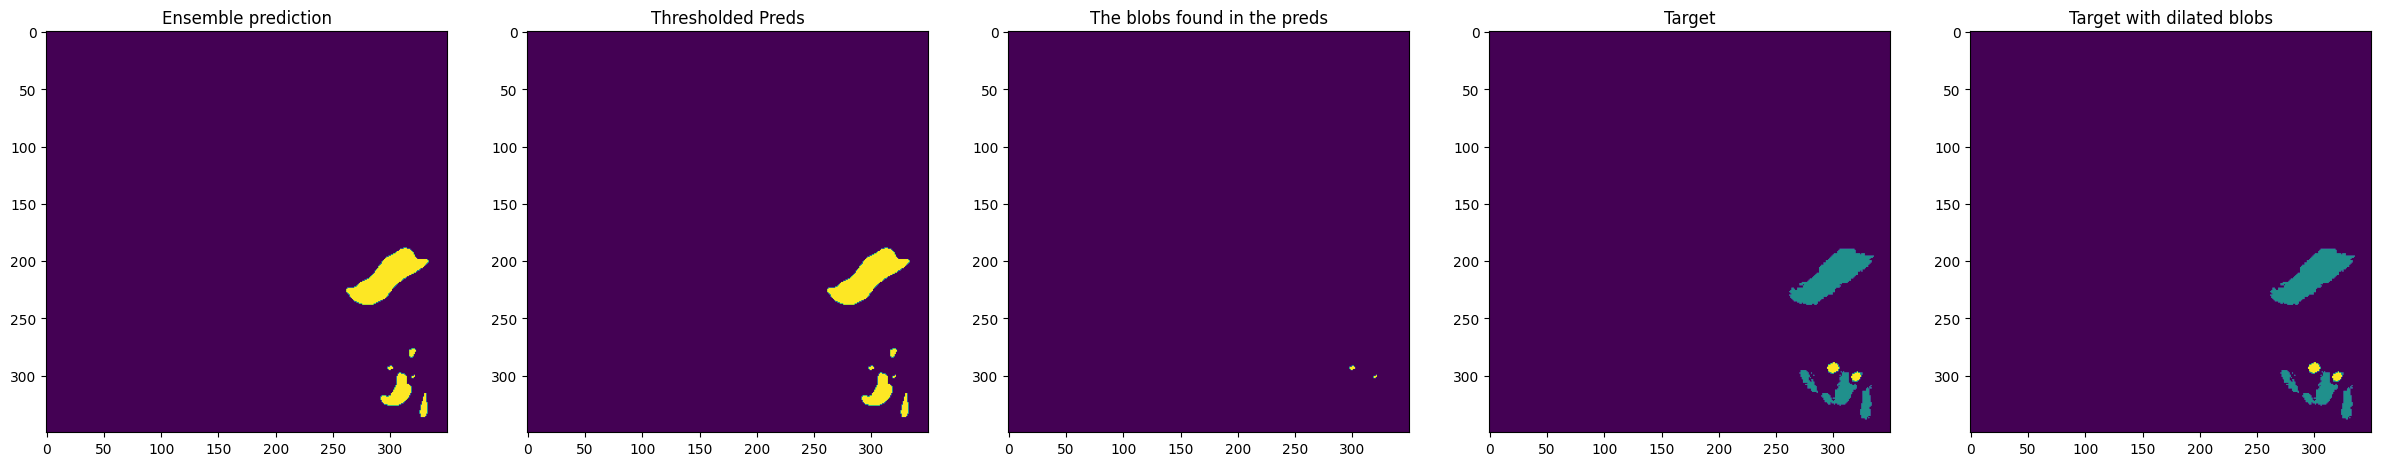

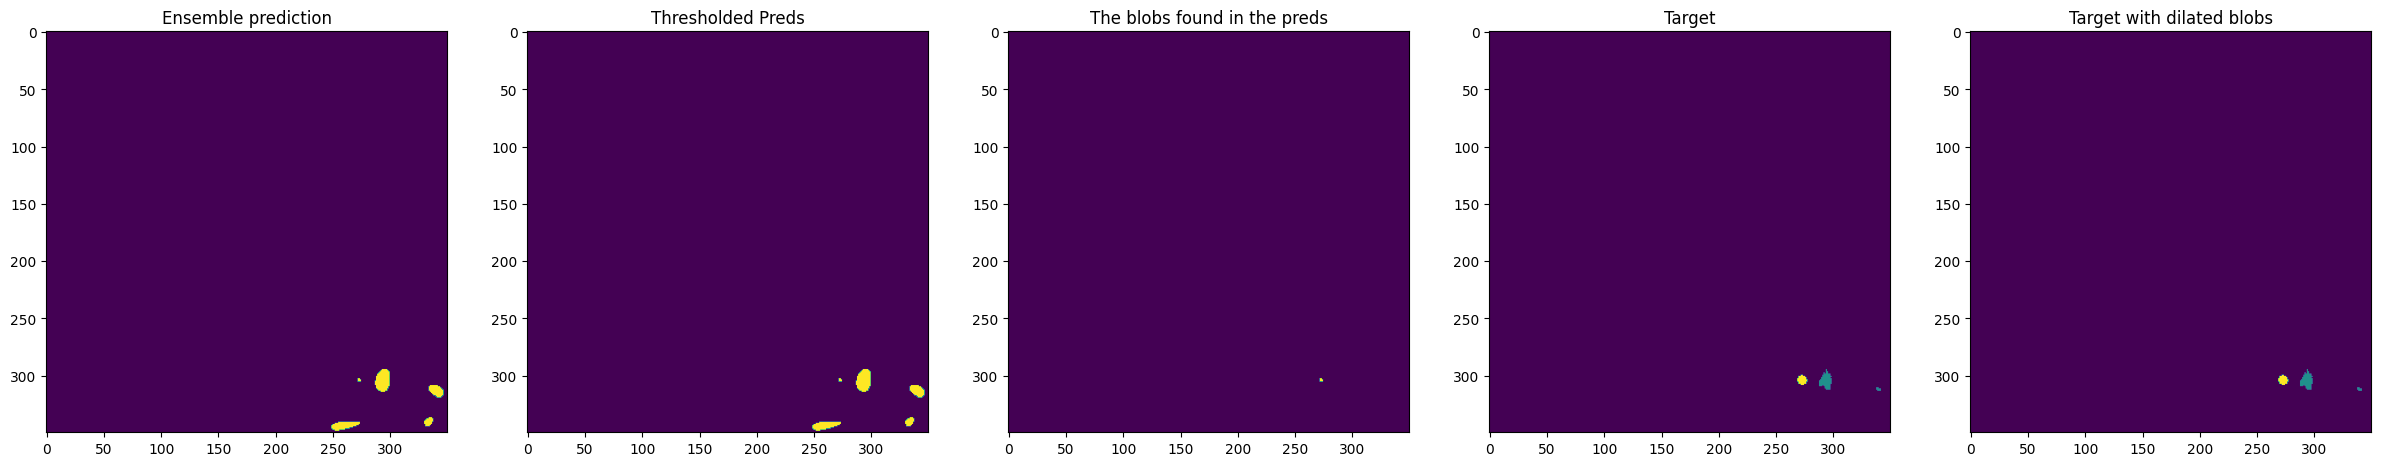

In [105]:
for n in range(50,55):
    fig, ax = plt.subplots(1, 5, figsize=(30, 15))
    ax[0].imshow(ensemble_preds[n])
    ax[0].set_title("Ensemble prediction")
    # plot the thresholded preds
    ensemble_preds = ensemble_preds > 0.5
    ax[1].imshow(ensemble_preds[n])
    ax[1].set_title("Thresholded Preds")
    ax[2].imshow(blobs[n])
    ax[2].set_title("The blobs found in the preds")
    ax[3].imshow(dilated_blobs[n])
    ax[3].set_title("Dilated blobs")
    # also include the labels but amplify the points where the blobs are found
    reshaped_targets = reshaped_targets.astype(float)
    reshaped_targets[blobs == 1] = 2
    ax[3].imshow(reshaped_targets[n])
    ax[3].set_title("Target")
    reshaped_targets[dilated_blobs == 1] = 2
    ax[4].imshow(reshaped_targets[n])
    ax[4].set_title("Target with dilated blobs")
    plt.show()

In [106]:
# now replace all parts of theensemble preds with the value of the dilated blobs if dialted blobs are 1
for i in range(ensemble_preds.shape[0]):
    ensemble_preds[i][dilated_blobs[i] == 1] = 1
# Now compute the dice score for the ensemble preds
ensemble_dice_score = 2 * np.sum(reshaped_targets * ensemble_preds) / (np.sum(reshaped_targets) + np.sum(ensemble_preds))
print(ensemble_dice_score)


0.7283991444909572
